# Preliminary operations

In [1]:
# General libraries
import pandas as pd
import numpy as np
import copy
import pickle
import os
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from math import sqrt
from scipy.ndimage import gaussian_filter1d

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, TimeDistributed
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

In [2]:
%run utils.ipynb

In [3]:
%run preprocessing.ipynb

In [4]:
%run preparation.ipynb

In [5]:
%run training_dense.ipynb

In [6]:
%run predict.ipynb

In [7]:
# If set to true, the next cells will retrain the model on training data.
# Otherwise, prediction mode will be set.
to_train = True

# Loading data

In [8]:
# Read training data
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [9]:
df.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

In [10]:
# Save interactive html visualization for training data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal</sup>"
save_path = 'html_plots/normal.html'
fig = px.line(df[5400:-1800], x = df[5400:-1800].index, y = df[5400:-1800].columns, title = title) # Delete stabilization time
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

# Preprocessing

In [11]:
# List of parameters for preprocessing
params = [
    ['rides_not_served', 'active_customers', 'avg_actual_expected_price', 'avg_actual_price', 'avg_actual_expected_price_30min', 'avg_actual_price_30min', 'avg_actual_expected_price_60min', 'avg_actual_price_60min'],
    True, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    0, # differencing
    True, # seasonality
    True # normalize
]
scaler_path = f"df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"

# Apply preprocessing strategy according to previous parameters selection
df_ = copy.deepcopy(df)
df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True)                # Save dataset to datasets/proc

(86400, 31)


# Preparation

In [12]:
# Prepare training set for the model
train_set = preparation(df_proc,
                        window_size = 0,   # Windowing for LSTM model
                        overlap = 0,       # Number of observation to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set. After cross-validation we use all training data

(86400, 31)


# Modeling

Epoch 1/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0721
Epoch 2/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0601
Epoch 3/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0547
Epoch 4/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0562
Epoch 5/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0625
Epoch 6/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0561
Epoch 7/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0545
Epoch 8/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0513
Epoch 9/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0456
Epoch 10/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0422
Epoch 11/500
1350/1350 [==============================] - 2s 1ms/step - loss: 0.0406
Epoch 12/500
1350/1350 [==============================] - 2s 1ms/step - lo

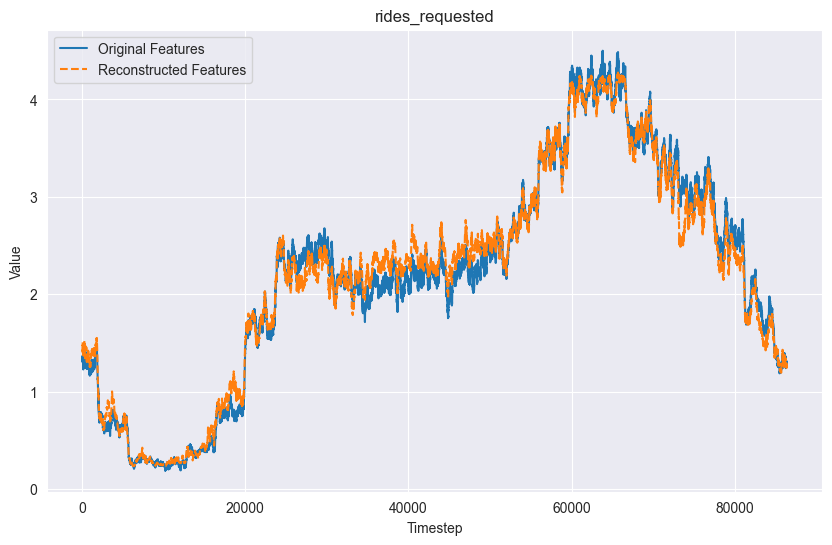

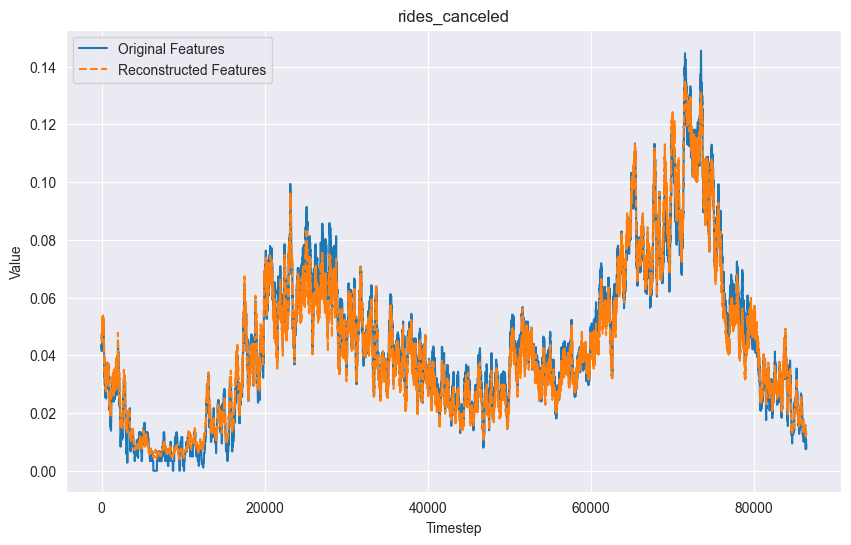

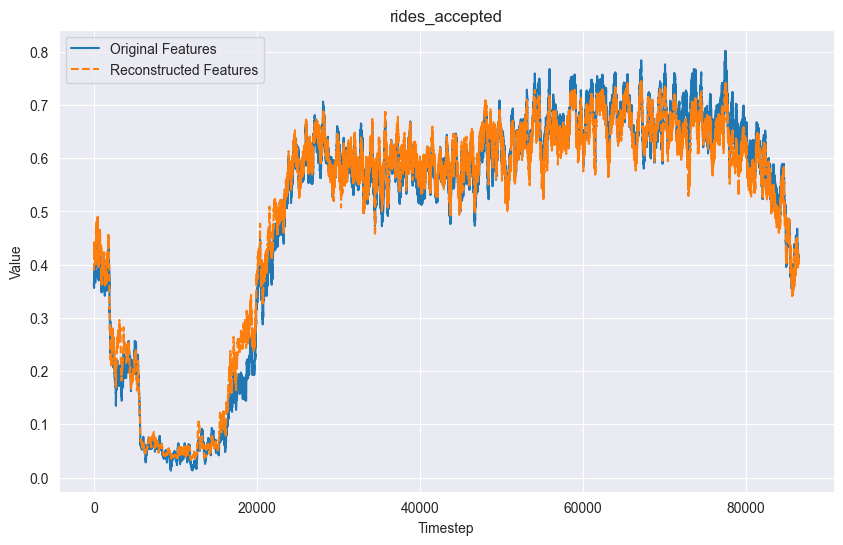

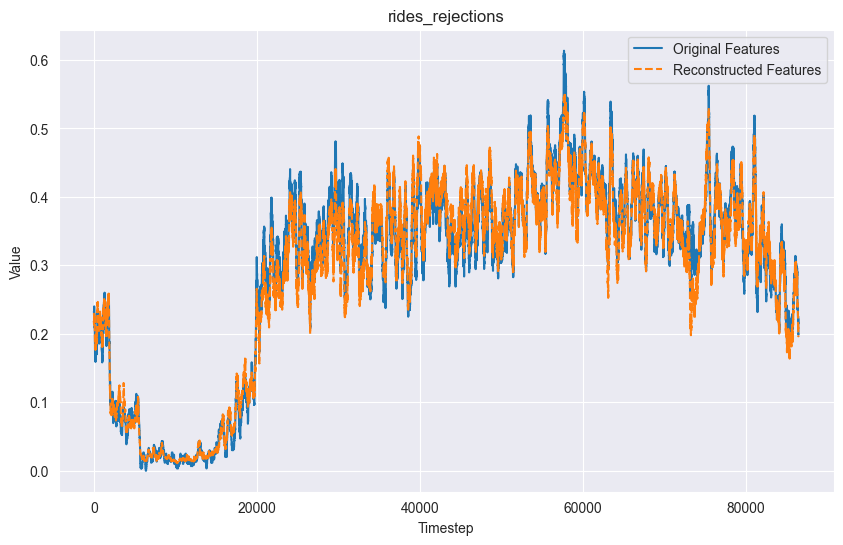

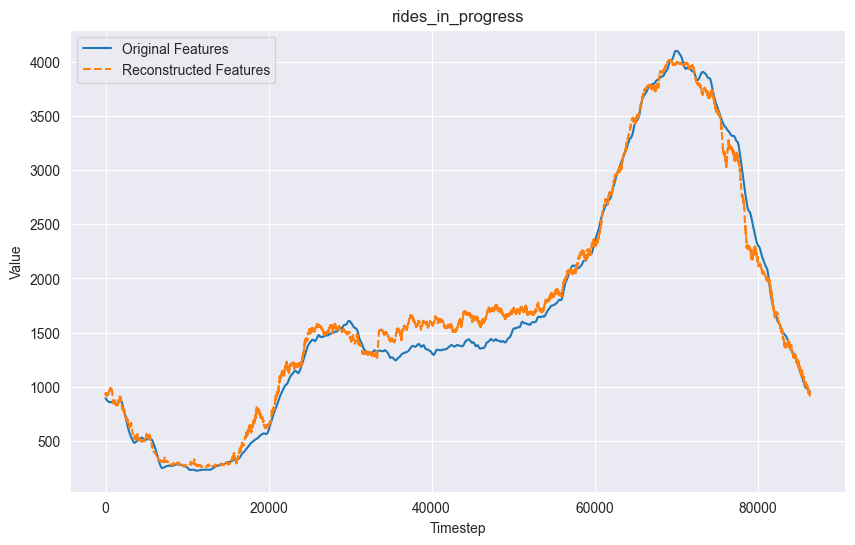

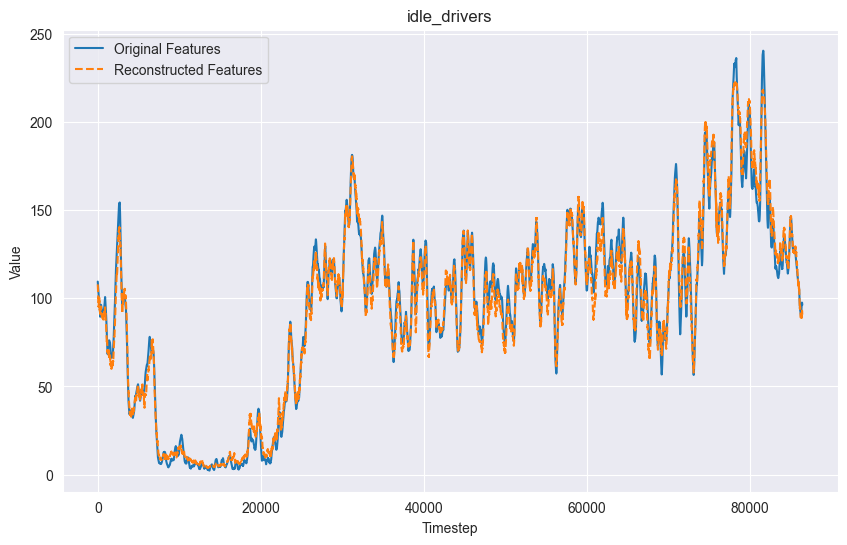

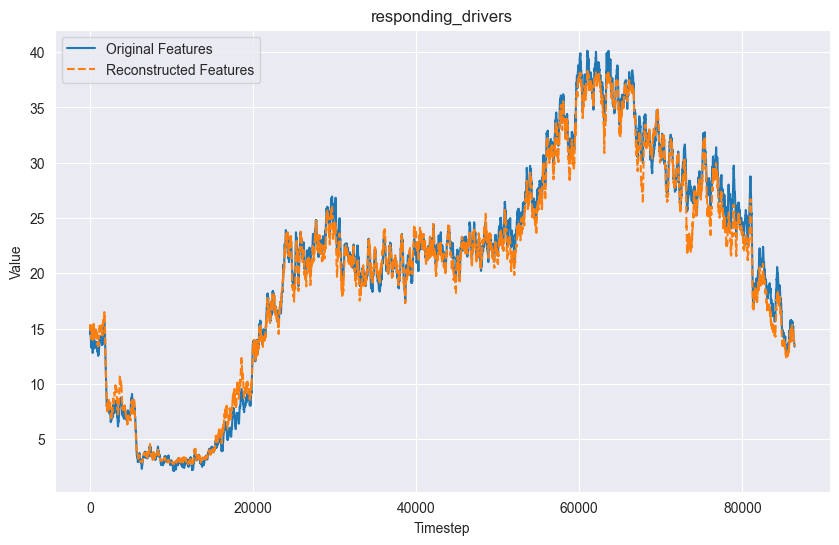

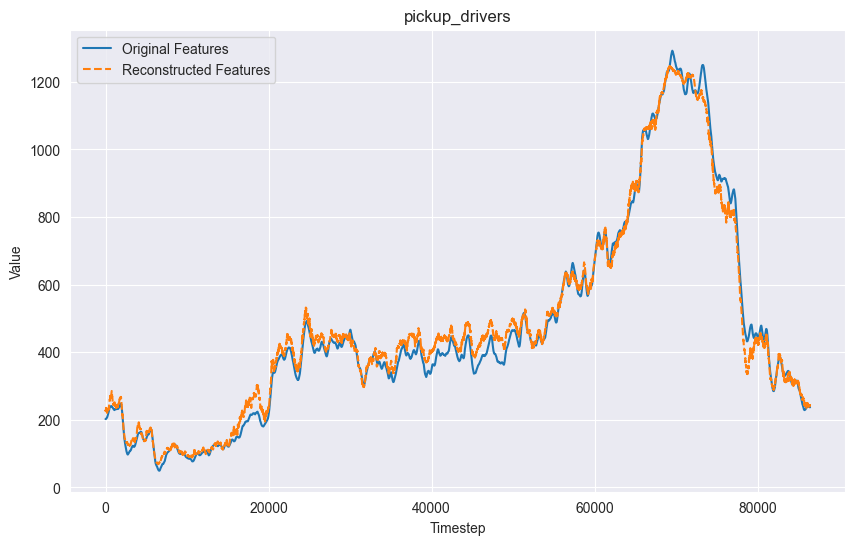

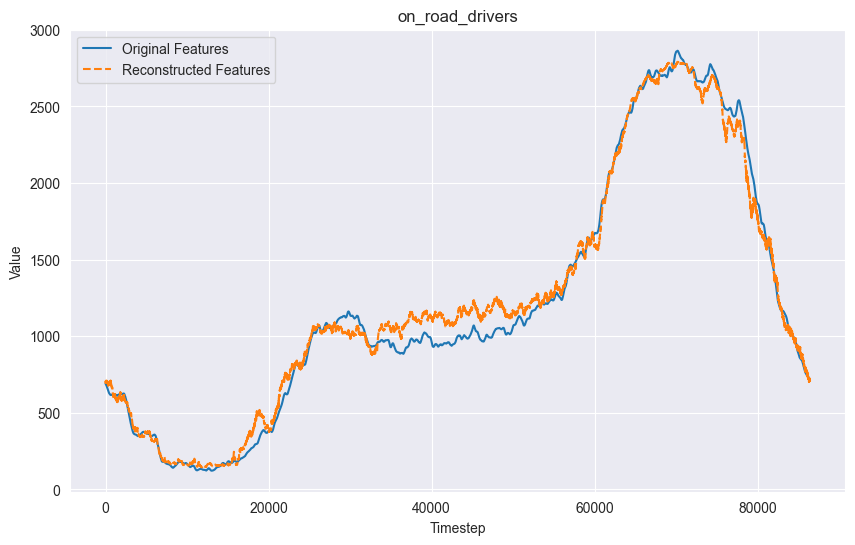

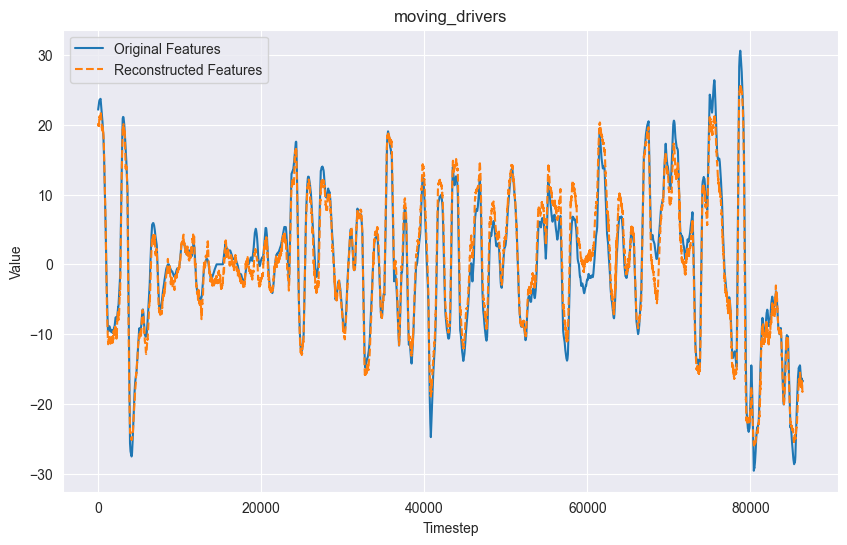

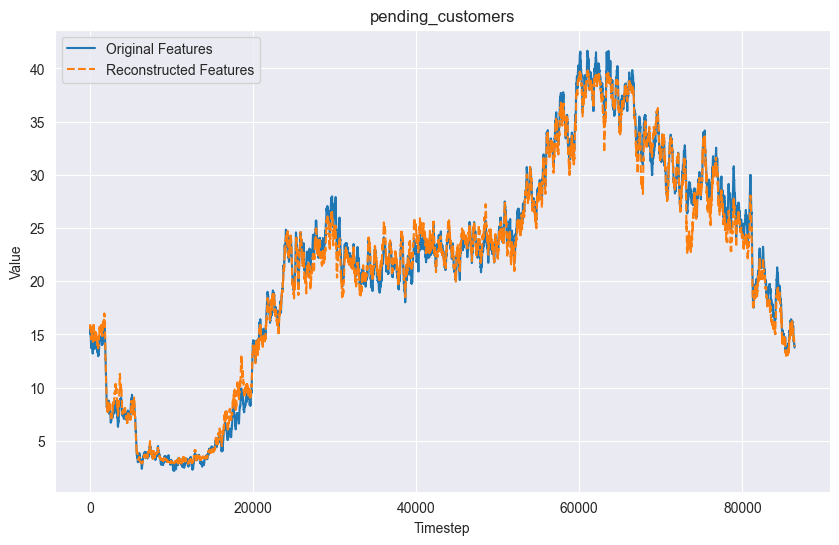

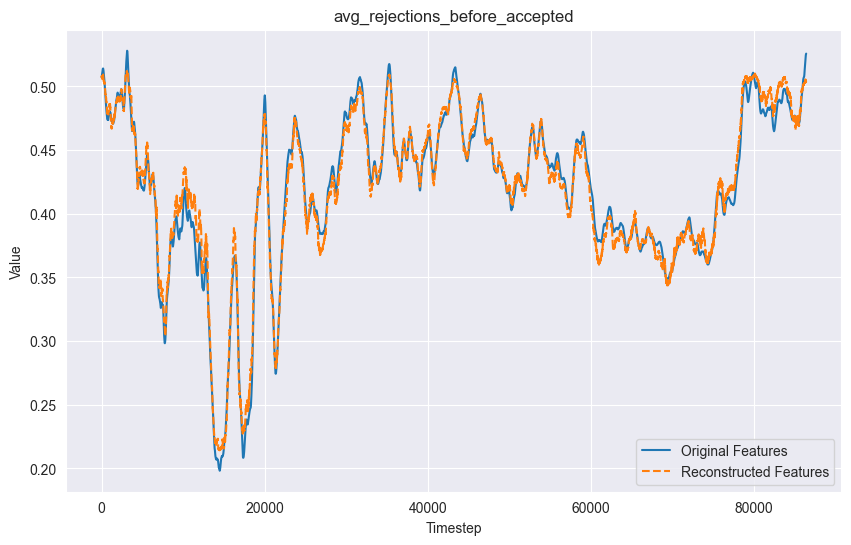

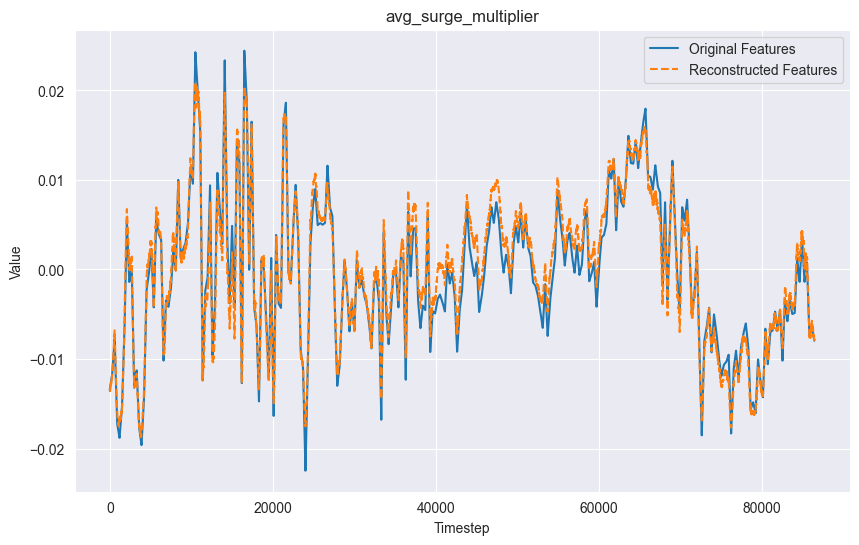

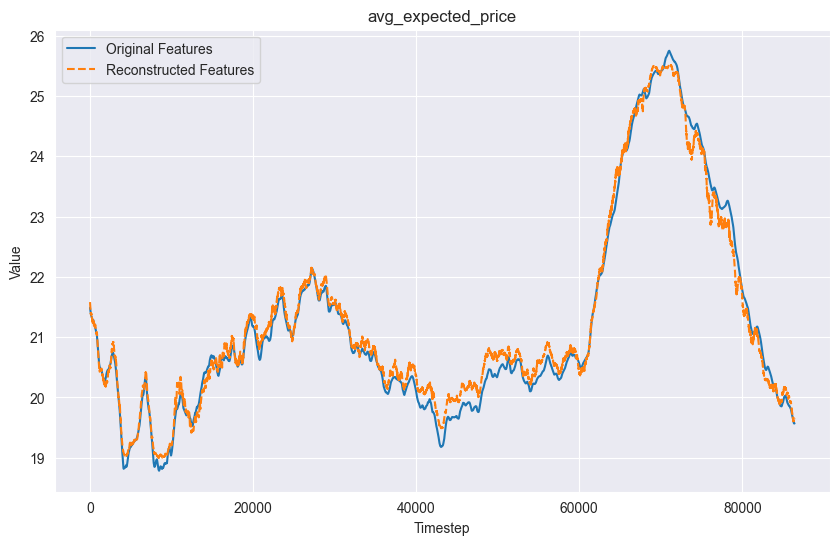

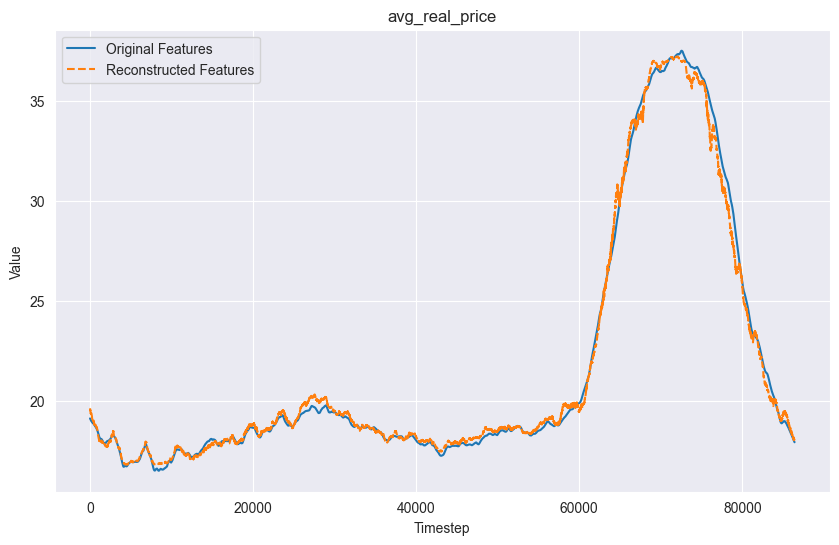

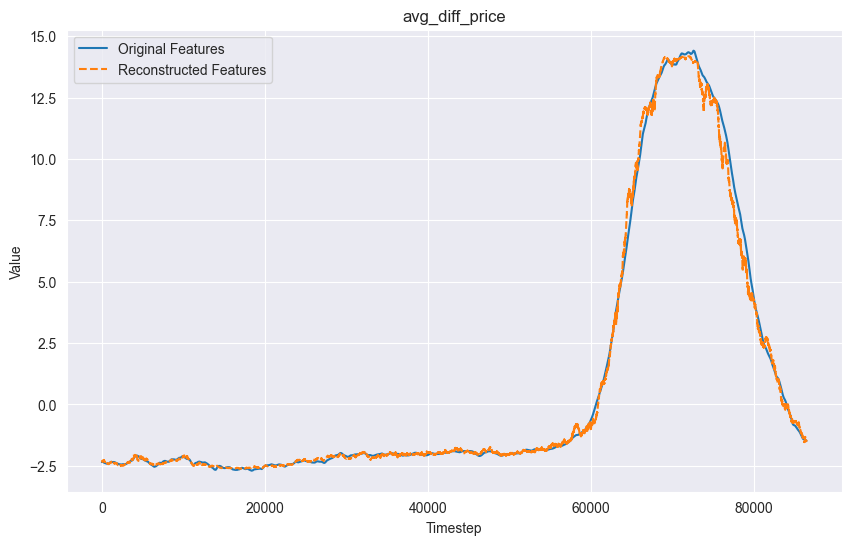

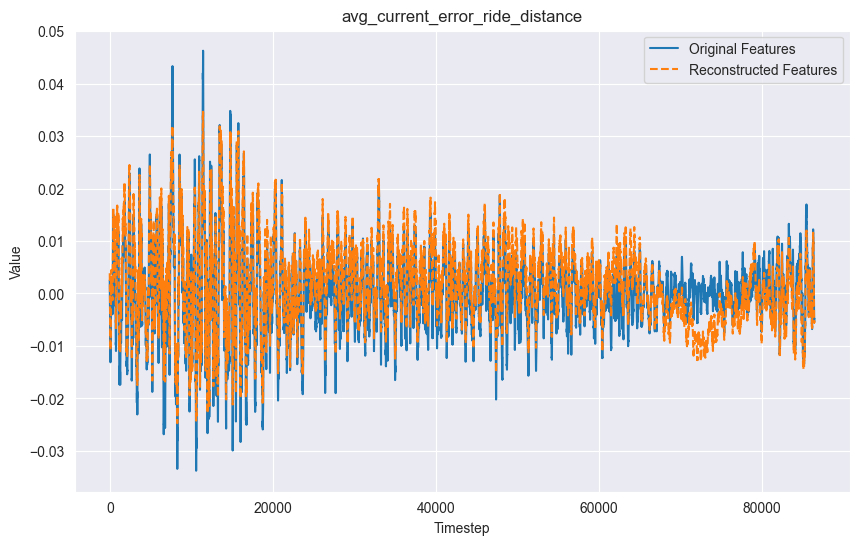

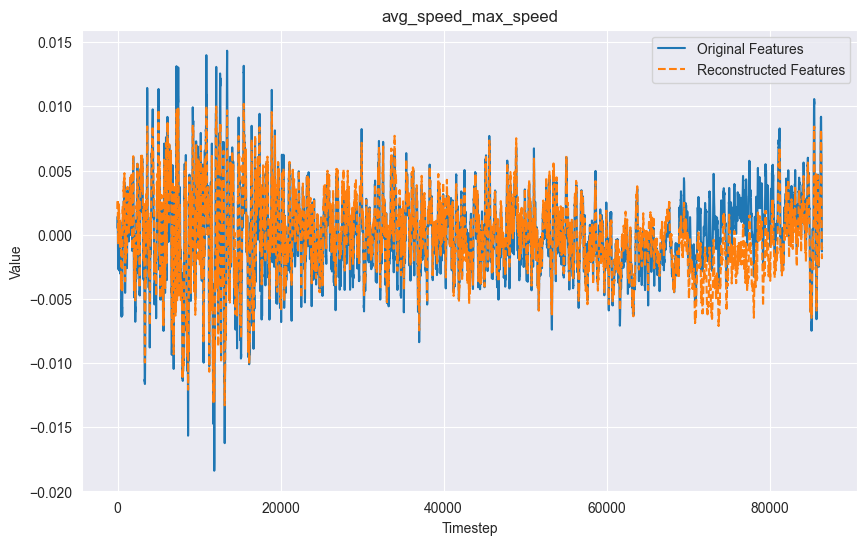

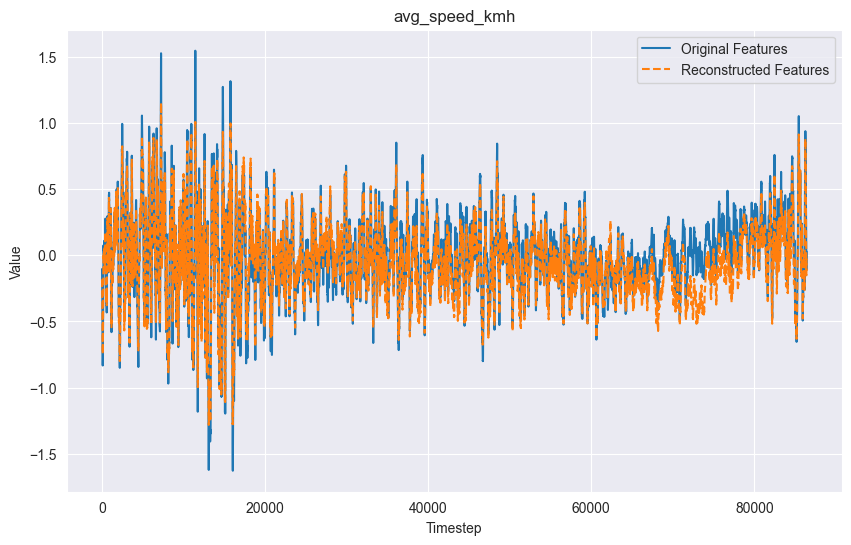

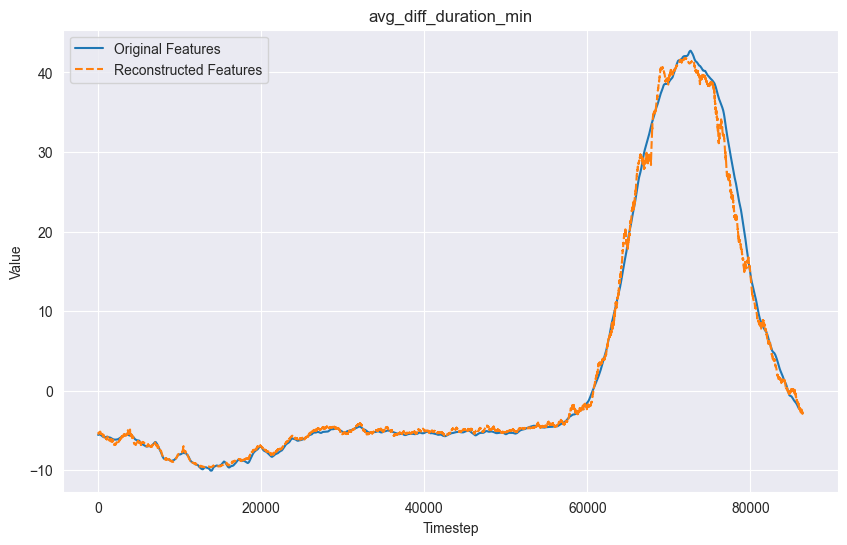

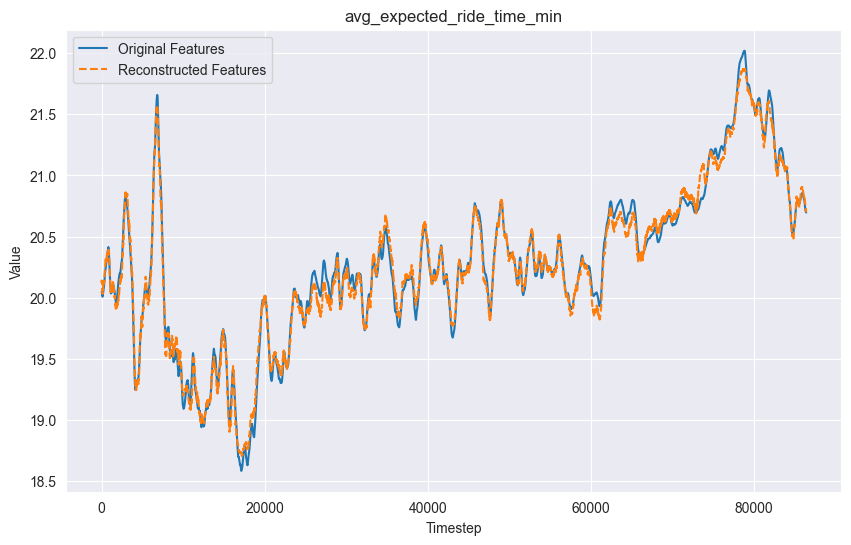

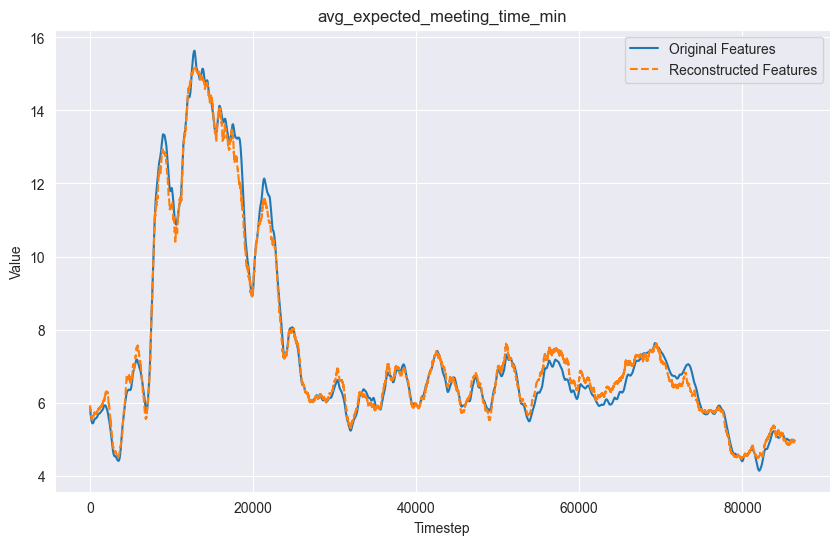

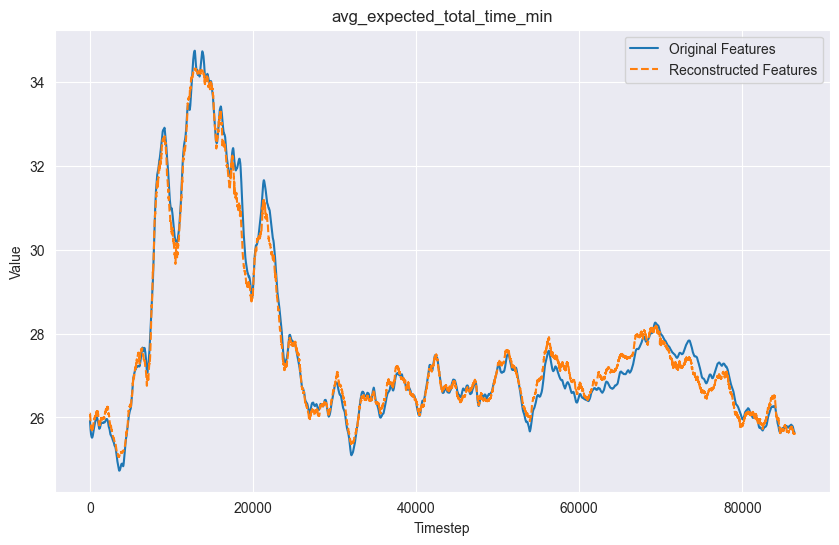

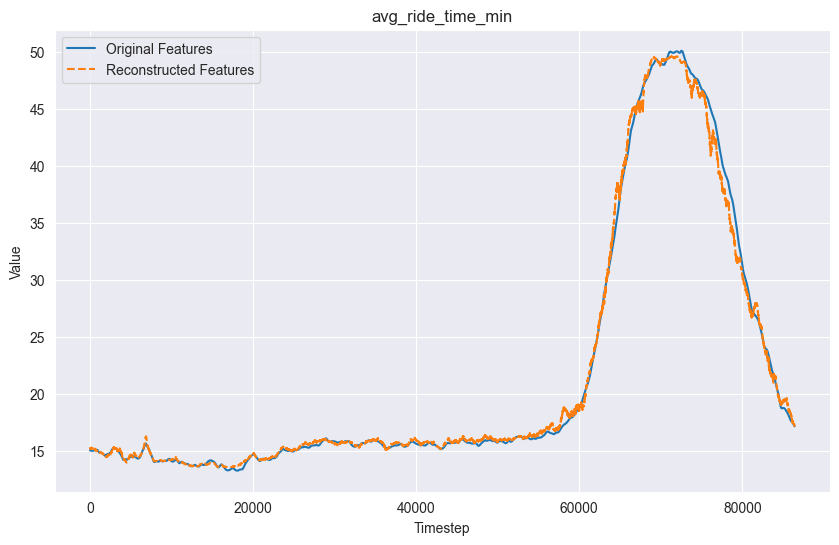

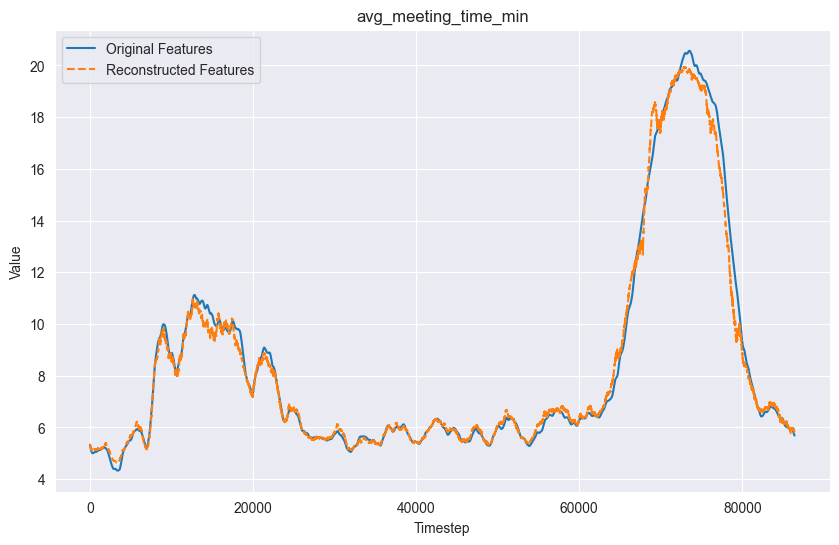

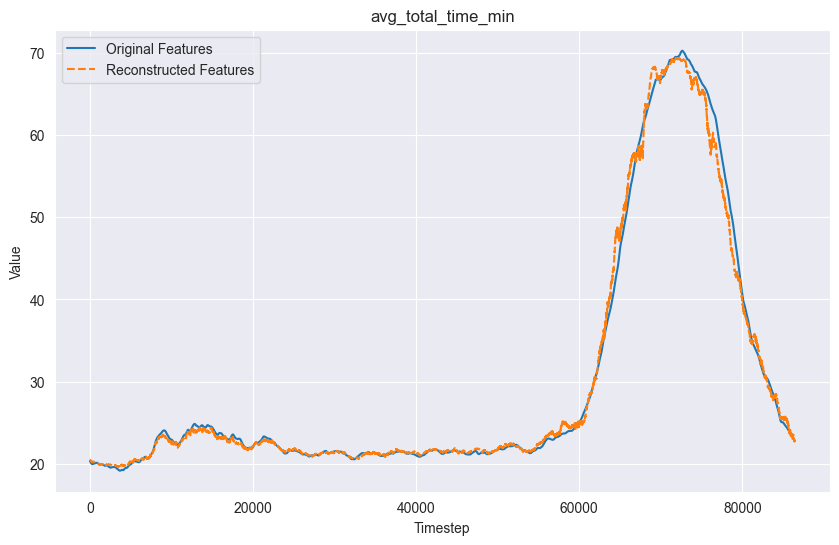

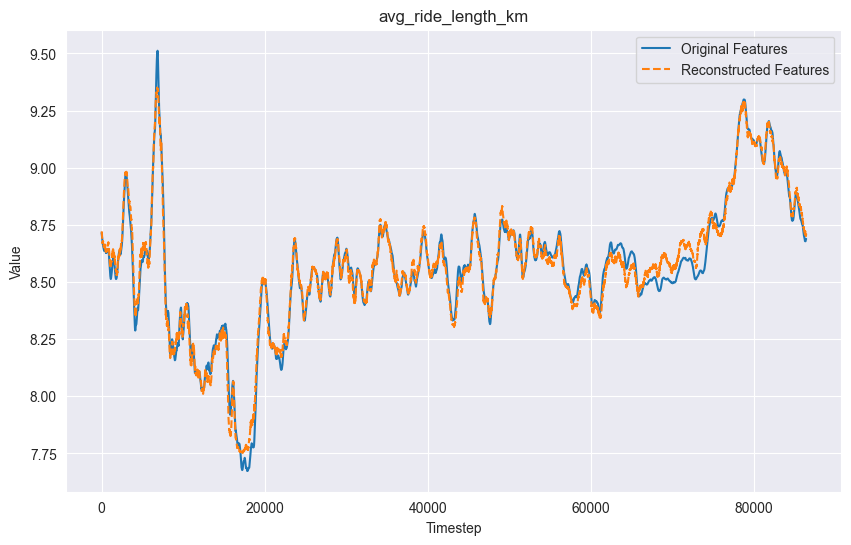

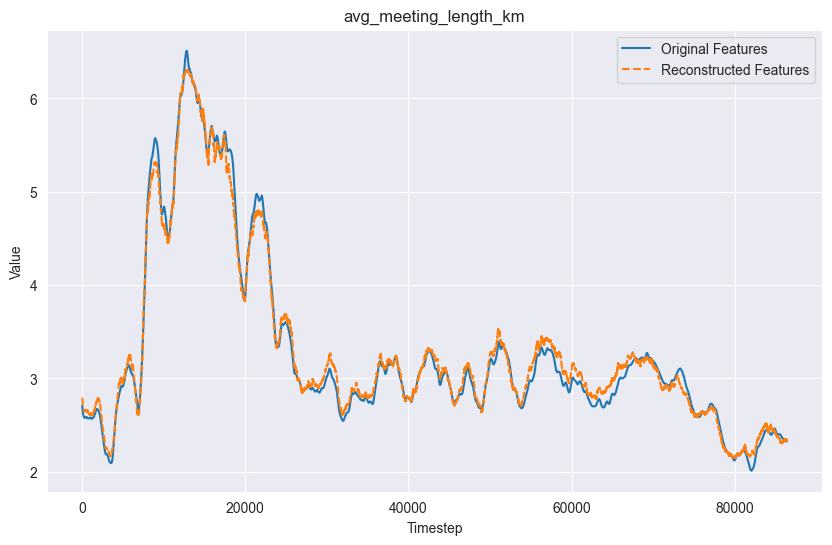

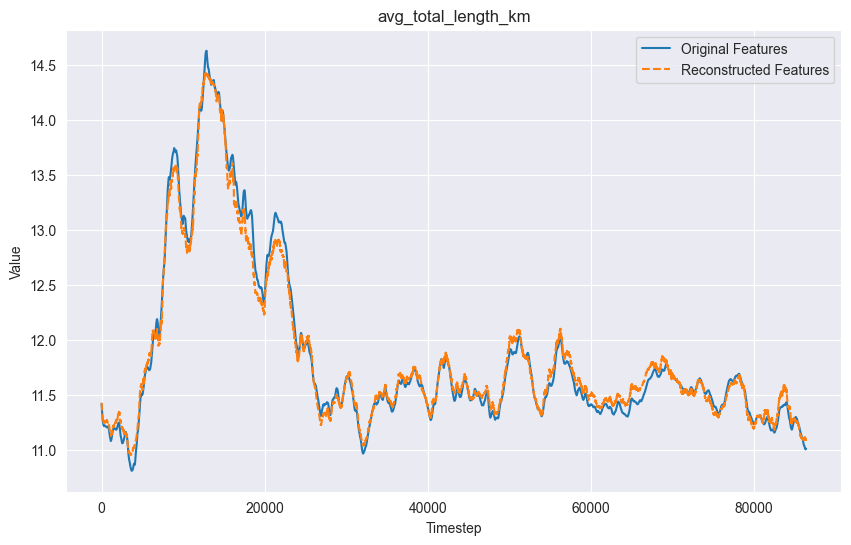

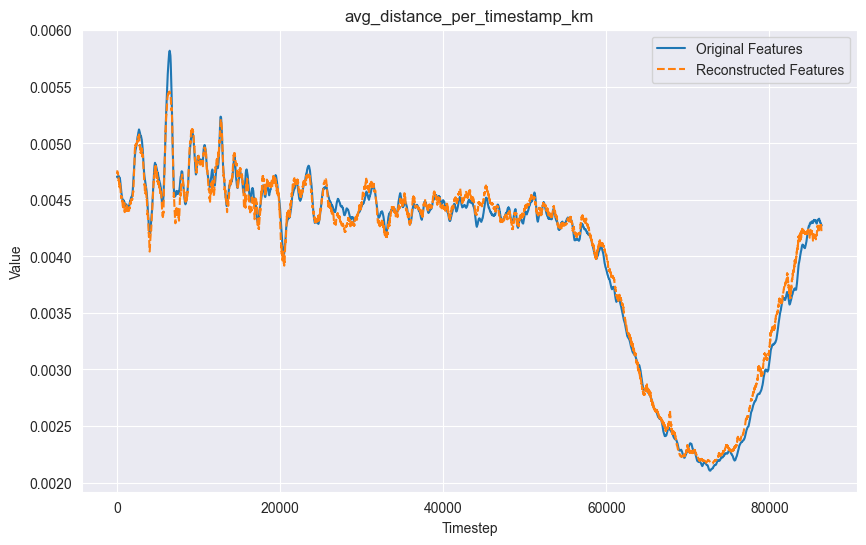

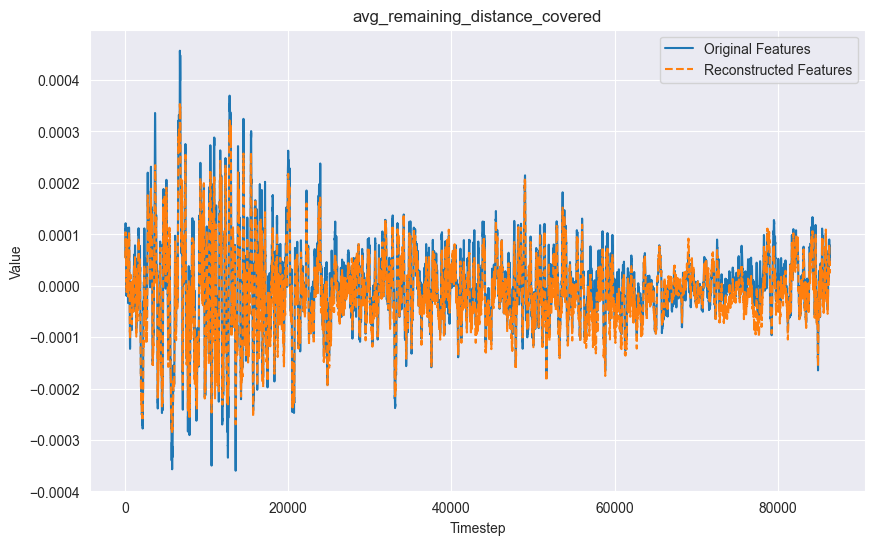

In [13]:
# Training
if to_train:
    history, model = training_dense(train_set,
                                   None,
                                   n_layers_encoder = 2,
                                   n_layers_decoder = 2,
                                   hidden_units = [128, 64, 32, 32, 64, 128],
                                   activation_hidden = 'tanh',
                                   activation_dense = 'sigmoid',
                                   dropout_rate = 0,
                                   learning_rate = 0.0001,
                                   n_epochs = 500,
                                   metric = 'mae',
                                   batch_size = 64,
                                   plot = True,                                   # Save history of training loss
                                   save = True)                                   # Save model to models/dense
    
    # Predict and assess performance on training set
    original, reconstructed = predict(model, train_set, scaler_path, recurrent = False)

    # Save metrics plots and dataframes
    num_features = min(train_set.shape[1], len(df_proc.columns))
    mae, mse, mape = save_predict_plots(original, reconstructed, df_proc.columns, num_features, scaler_path, model_type = 'dense', plot = False, compute_df = True)

    # Plot training set reconstruction performance
    for column in range(0, len(df_proc.columns)):
        plt.figure(figsize = (10, 6))
        plt.plot(original[:, column], label = 'Original Features')
        plt.plot(reconstructed[:, column], label = 'Reconstructed Features', linestyle='--')
        plt.title(df_proc.columns[column])
        plt.xlabel("Timestep")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
else:
    # Just load the model already trained. Be sure to enter the right path
    model_path = 'models/dense/2_2_128_128_tanh_sigmoid_0_00001_500_mae_64.pkl'
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

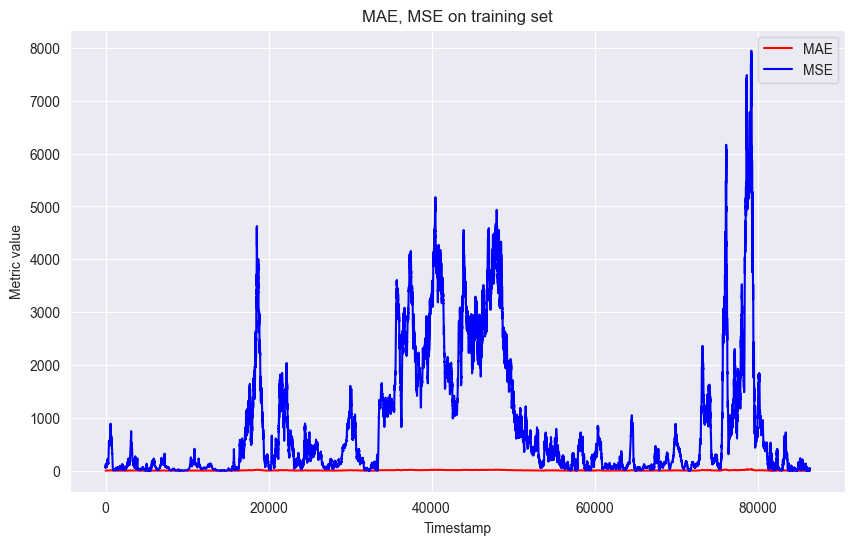

In [14]:
# Load metrics training dataset
mae_df = pd.read_csv("predictions/dense/dense_mae.csv")
mse_df = pd.read_csv("predictions/dense/dense_mse.csv")
mape_df = pd.read_csv("predictions/dense/dense_mape.csv")

# Compute mean mae and mse across columns on training set 
mean_err_mae = mae_df.mean(axis = 1)
mean_err_mse = mse_df.mean(axis = 1)
plt.figure(figsize = (10, 6))
plt.plot(mean_err_mae, color = 'r', label = 'MAE')
plt.plot(mean_err_mse, color = 'b', label = 'MSE')
plt.title('MAE, MSE on training set')
plt.xlabel('Timestamp')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
if to_train:
    # Set different percentile thresholds for the reconstruction error
    percentile_95 = 0.95
    percentile_97 = 0.97
    percentile_99 = 0.99
    percentile_999 = 0.999
    mae_df = pd.read_csv("predictions/dense/dense_mae.csv")
    for indicator in mae_df:
        mae_df[indicator] = (mae_df[indicator] - min(mae_df[indicator])) / (max(mae_df[indicator]) - min(mae_df[indicator]))
    mae_95 = mae_df[1800:].mean(axis = 1).quantile(percentile_95)
    mae_97 = mae_df[1800:].mean(axis = 1).quantile(percentile_97)
    mae_99 = mae_df[1800:].mean(axis = 1).quantile(percentile_99)
    mae_999 = mae_df[1800:].mean(axis = 1).quantile(percentile_999)
    mse_df = pd.read_csv("predictions/dense/dense_mse.csv")
    for indicator in mse_df:
        mse_df[indicator] = (mse_df[indicator] - min(mse_df[indicator])) / (max(mse_df[indicator]) - min(mse_df[indicator]))
    mse_95 = mae_df[1800:].mean(axis = 1).quantile(percentile_95)
    mse_97 = mse_df[1800:].mean(axis = 1).quantile(percentile_97)
    mse_99 = mse_df[1800:].mean(axis = 1).quantile(percentile_99)
    mse_999 = mse_df[1800:].mean(axis = 1).quantile(percentile_999)
    mape_df = pd.read_csv("predictions/dense/dense_mape.csv")
    for indicator in mape_df:
        mape_df[indicator] = (mape_df[indicator] - min(mape_df[indicator])) / (max(mape_df[indicator]) - min(mape_df[indicator]))
    mape_95 = mape_df[1800:].mean(axis = 1).quantile(percentile_95)
    mape_97 = mape_df[1800:].mean(axis = 1).quantile(percentile_97)
    mape_99 = mape_df[1800:].mean(axis = 1).quantile(percentile_99)
    mape_999 = mape_df[1800:].mean(axis = 1).quantile(percentile_999)
    # Save dataframe with different percentile thresholds
    metrics_dict = {
        'mae_95': [mae_95],
        'mae_97': [mae_97],
        'mae_99': [mae_99],
        'mae_999': [mae_999],
        'mse_95': [mse_95],
        'mse_97': [mse_97],
        'mse_99': [mse_99],
        'mse_999': [mse_999],
        'mape_95': [mape_95],
        'mape_97': [mape_97],
        'mape_99': [mape_99],
        'mape_999': [mape_999]
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df.to_csv('metrics/metrics_dense.csv', index = False)
else:
    # Or just load previously defined metrics dataset
    metrics_df = pd.read_csv('metrics/metrics_dense.csv')

# Predicting

In [16]:
# Enter fail name and hour of the day (currently only "day", i.e., noon)
#fail = 'underground_greedy_dynamic_2'
fail = 'underground'
hour = 'day'

In [17]:
# Read test data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)
assert len(df.columns) == len(df_fail.columns)

In [18]:
# Save interactive html visualization for test data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: {fail}, Hour: {hour}</sup>"
save_path = 'html_plots/' + fail + '_' + hour + '.html'
fig = px.line(df_fail[5400:-1800], x = df_fail[5400:-1800].index, y = df_fail[5400:-1800].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [19]:
df_fail_ = copy.deepcopy(df_fail)
# Apply preprocessing strategy according to previous parameters selection
df_proc_fail, scaler_ = preprocessing(df_fail_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = params[7],
                               seasonality = params[8],
                               normalize = params[9],
                               load_scaler = True,
                               save = False)

(10800, 31)


In [20]:
# Prepare test set for the model
test_set_fail = preparation(df_proc_fail,
                            window_size = 0,
                            overlap = 0,
                            val_hours = 0)

(10800, 31)


338/338 [==============================] - 0s 334us/step
Mean MAE: 0        51.374213
1        51.396618
2         51.46478
3         51.41514
4        51.473532
           ...    
10795    71.455736
10796    71.712481
10797    71.698461
10798    71.879309
10799    71.616651
Length: 10800, dtype: object
Mean MSE: 0        32983.731821
1        33011.593935
2        33071.419505
3        33025.307589
4        33073.192364
             ...     
10795    59278.293453
10796      59774.9795
10797    59749.221309
10798    60085.854003
10799    59575.601171
Length: 10800, dtype: object
Mean MAPE: 0        2.504786
1        3.239233
2        3.814323
3        4.559804
4        5.564487
           ...   
10795    0.633054
10796    0.633439
10797    0.633184
10798    0.627913
10799    0.627262
Length: 10800, dtype: object


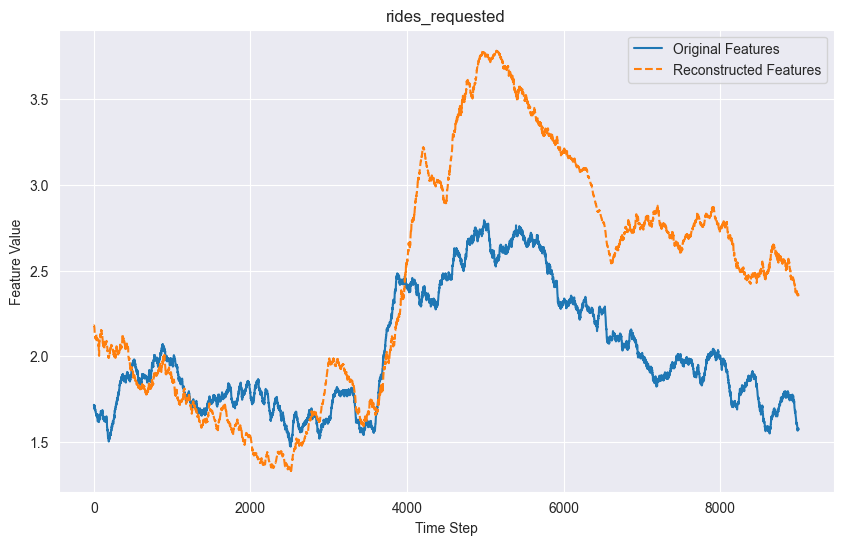

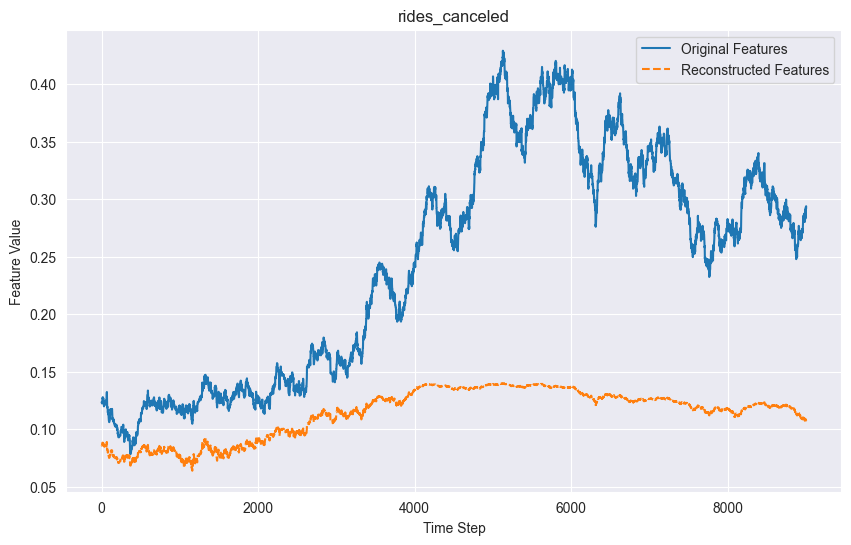

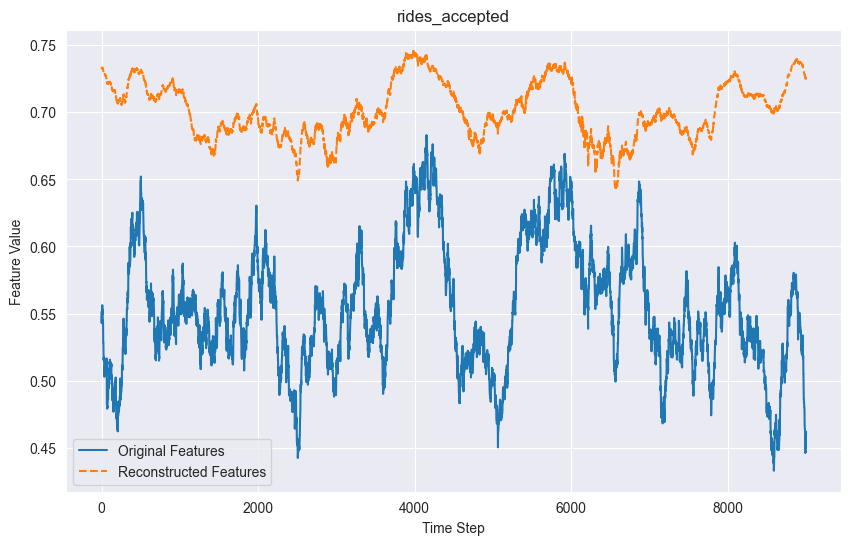

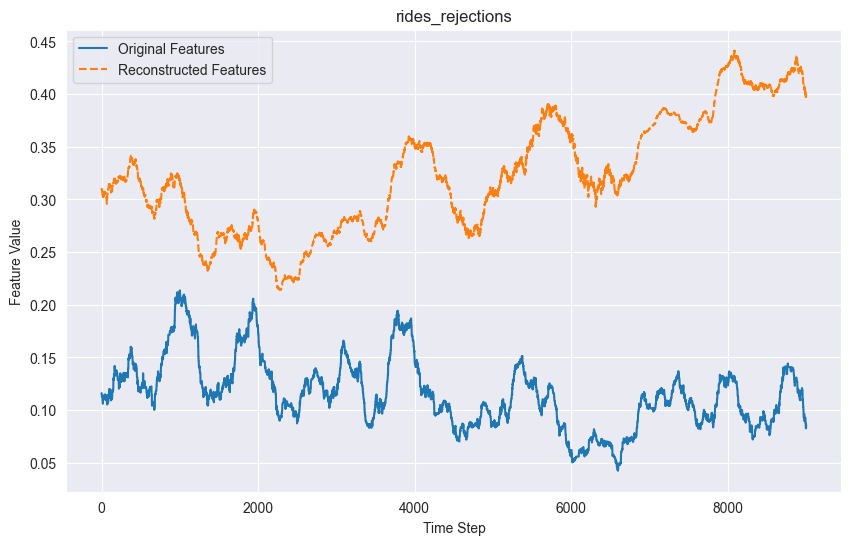

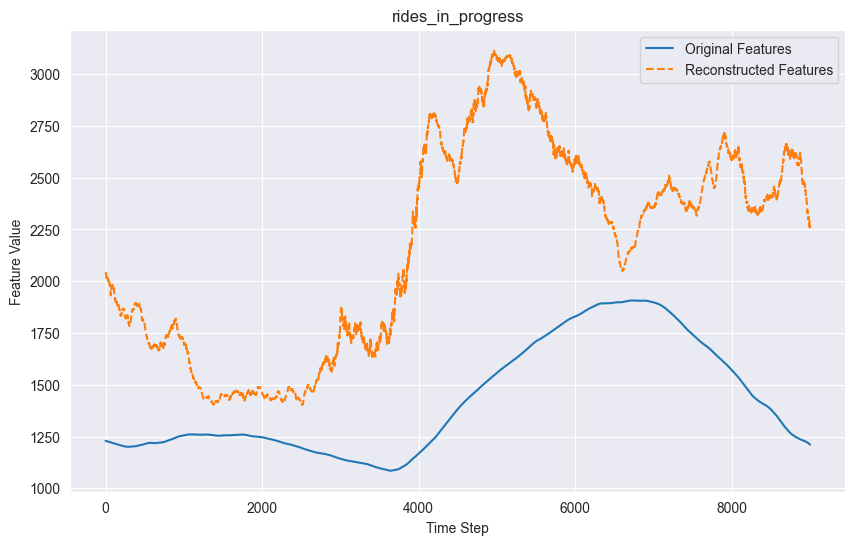

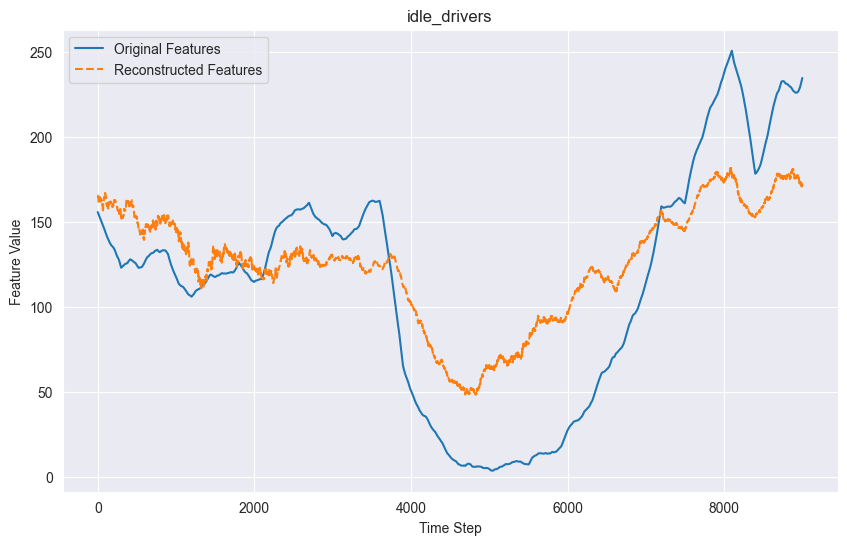

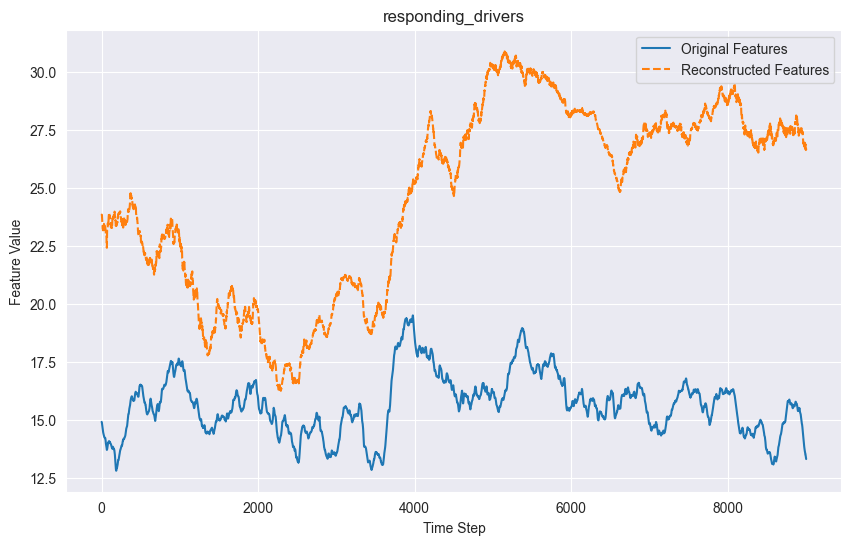

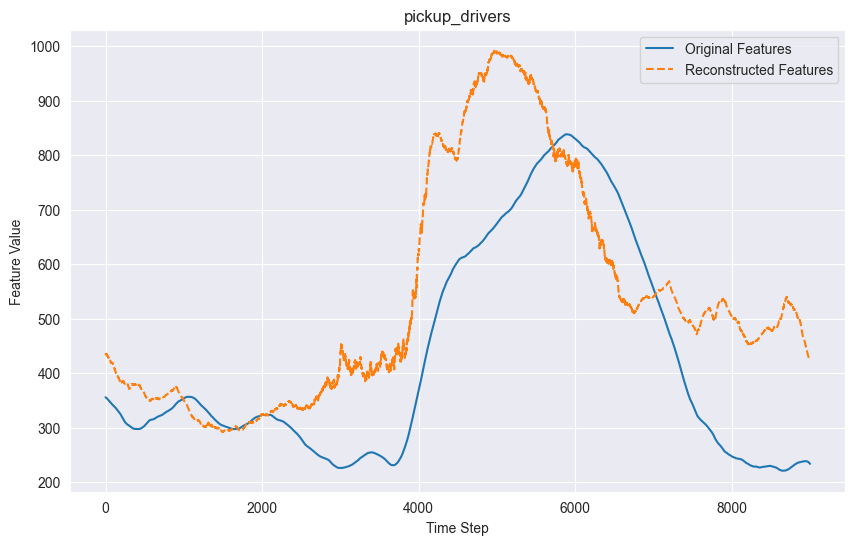

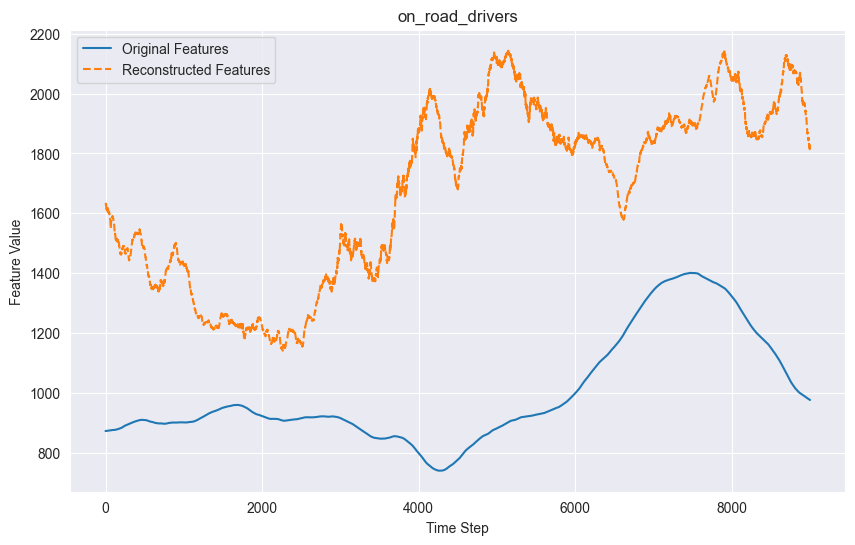

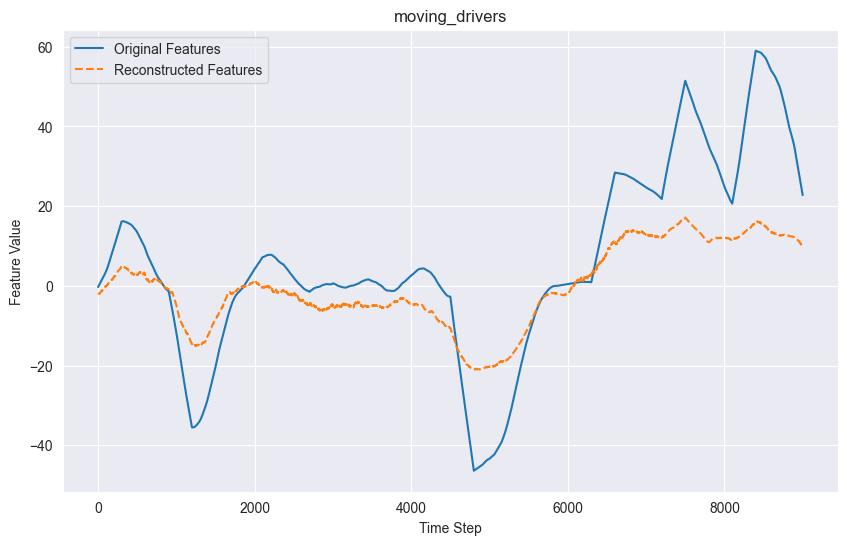

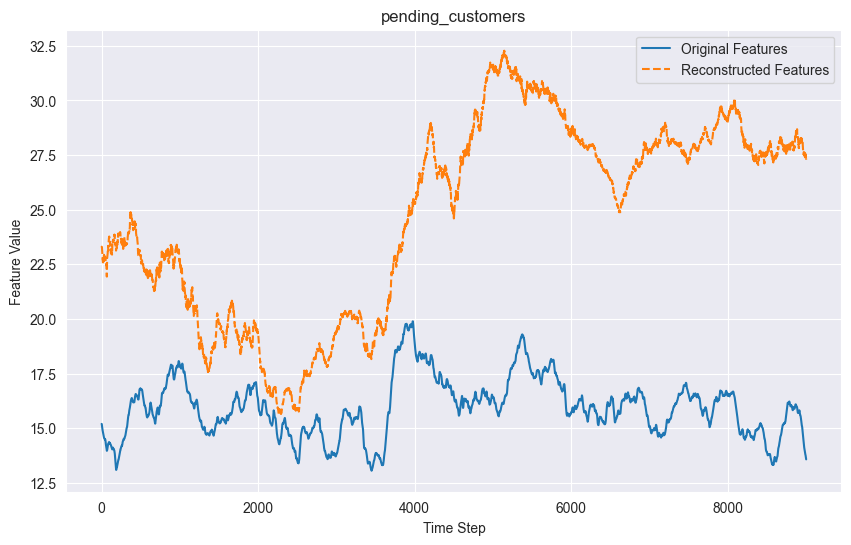

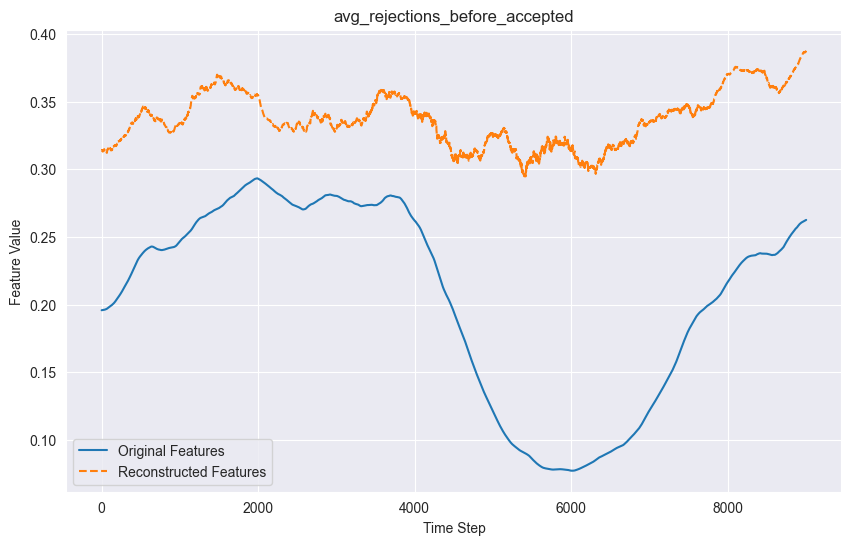

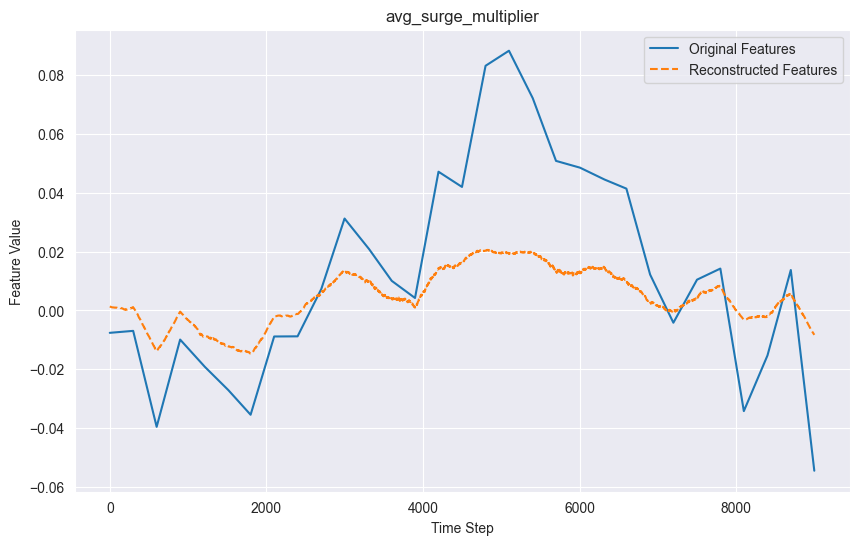

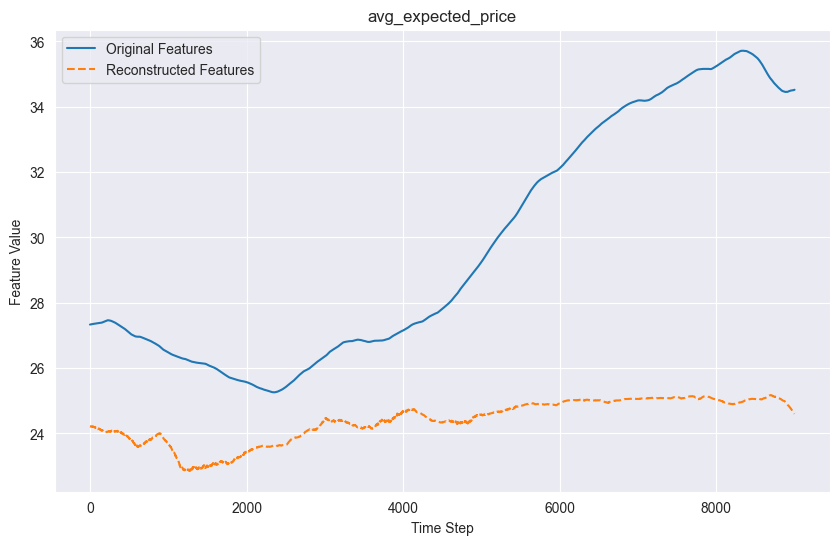

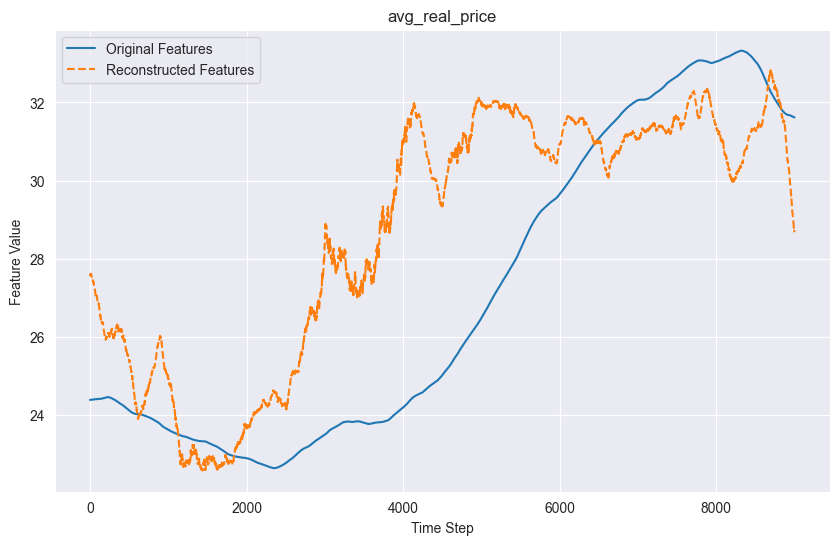

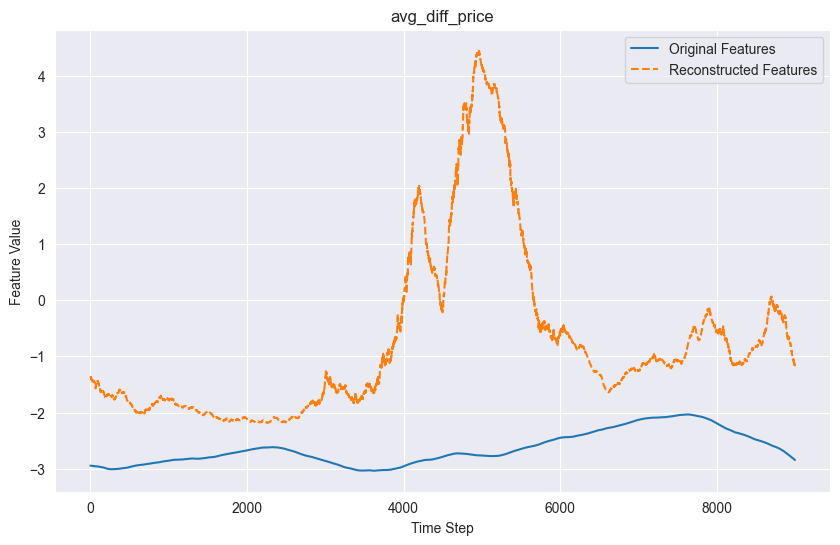

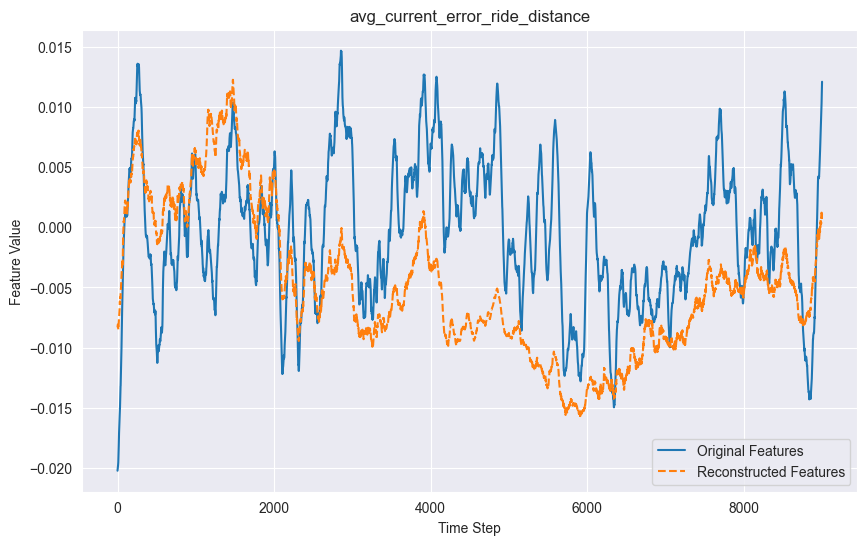

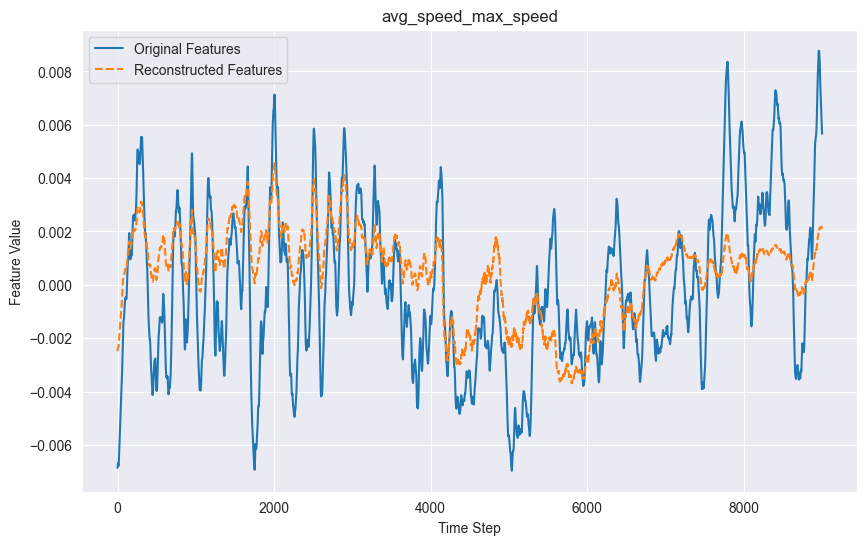

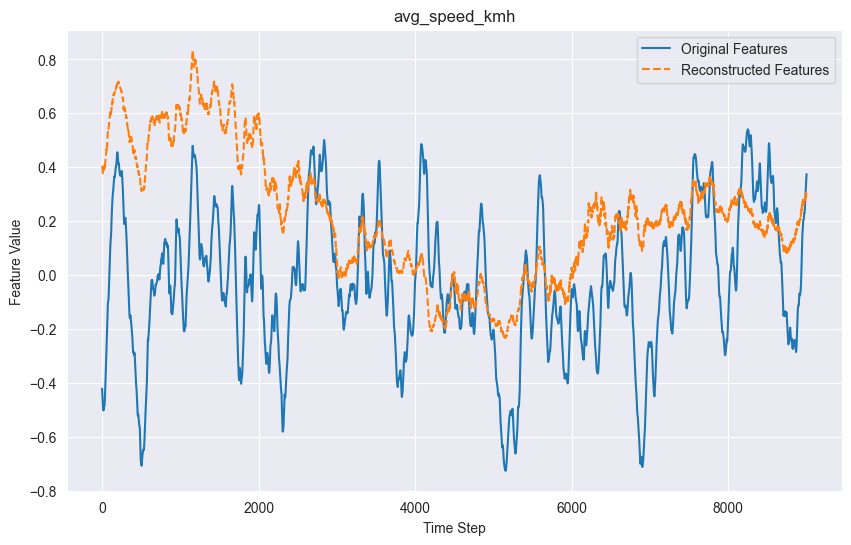

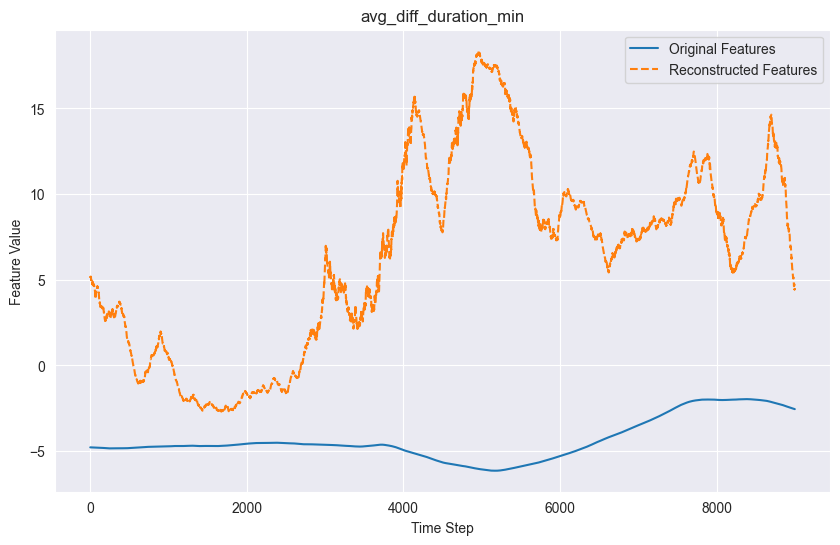

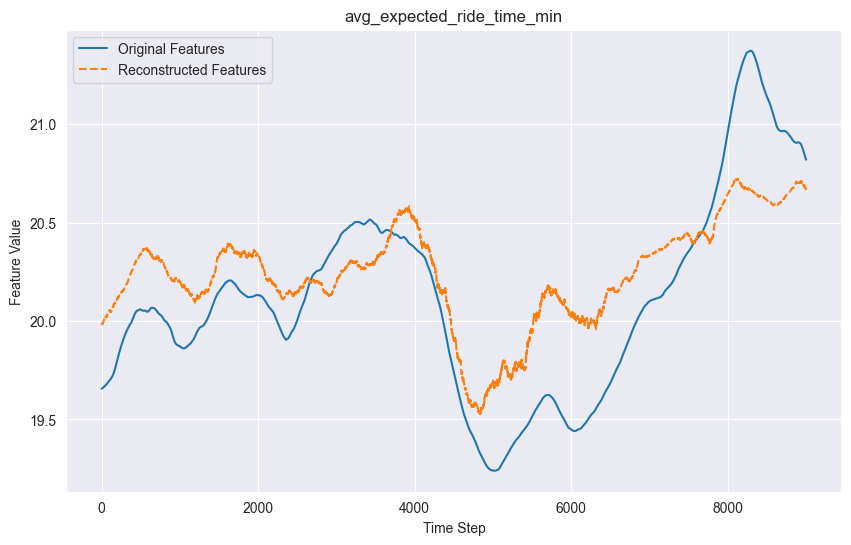

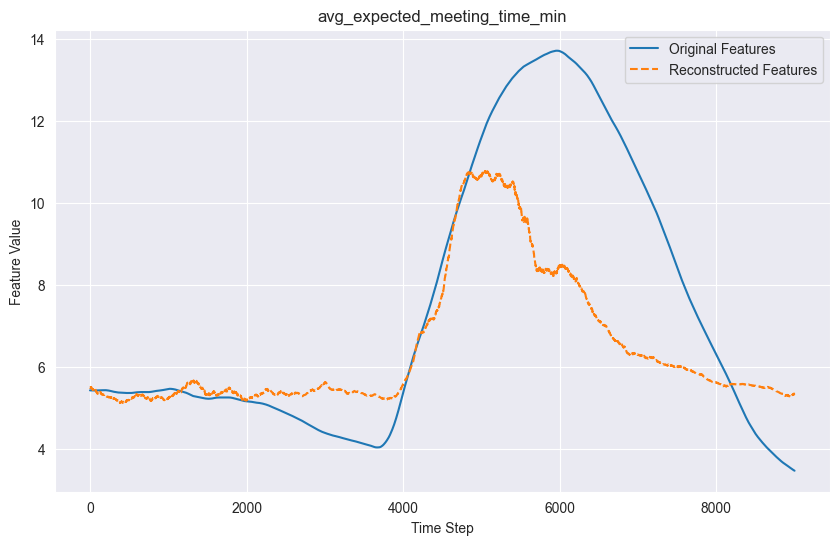

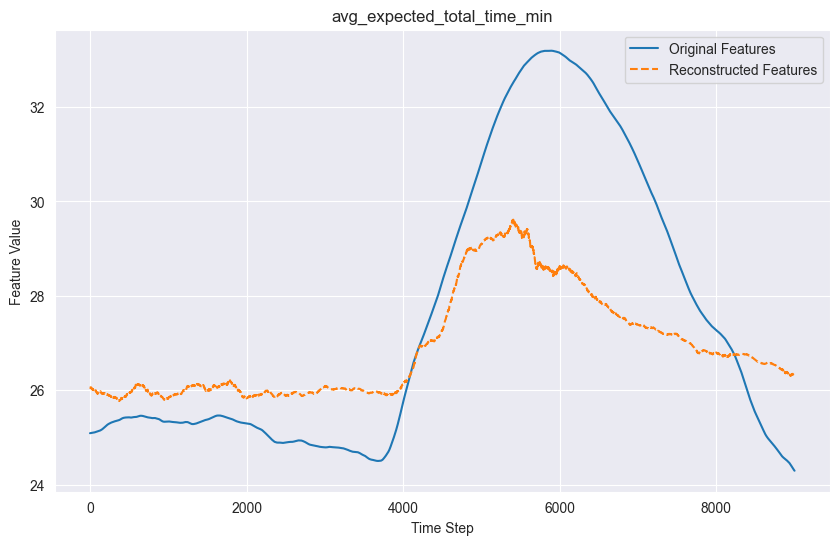

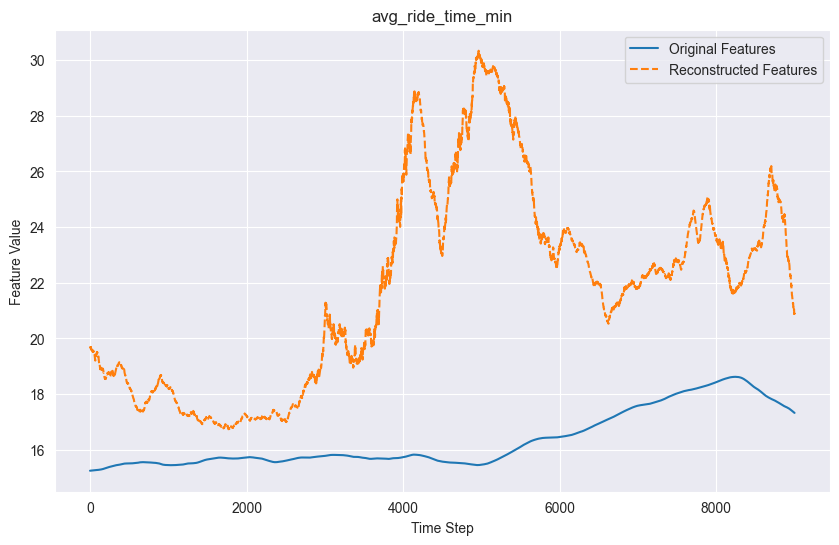

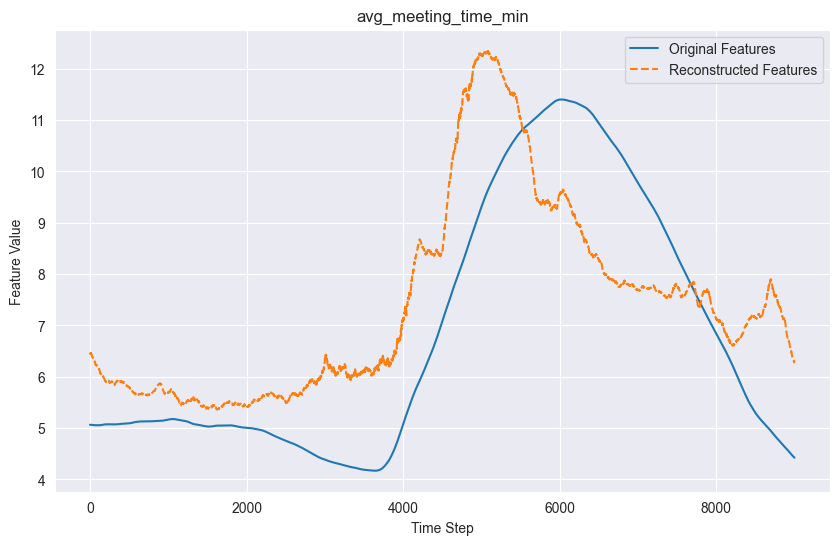

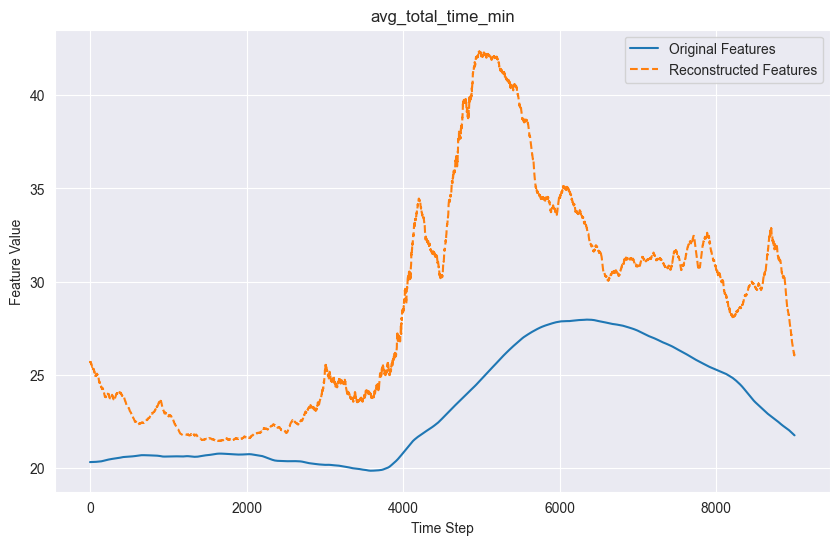

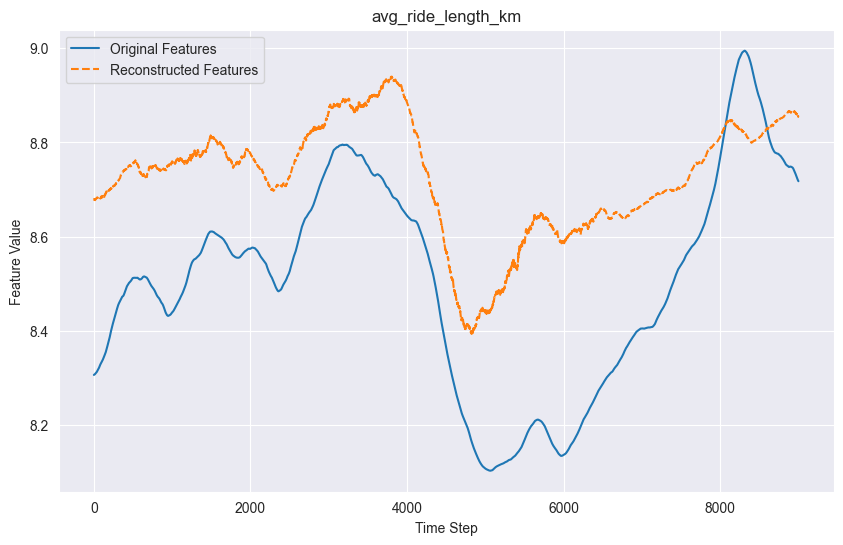

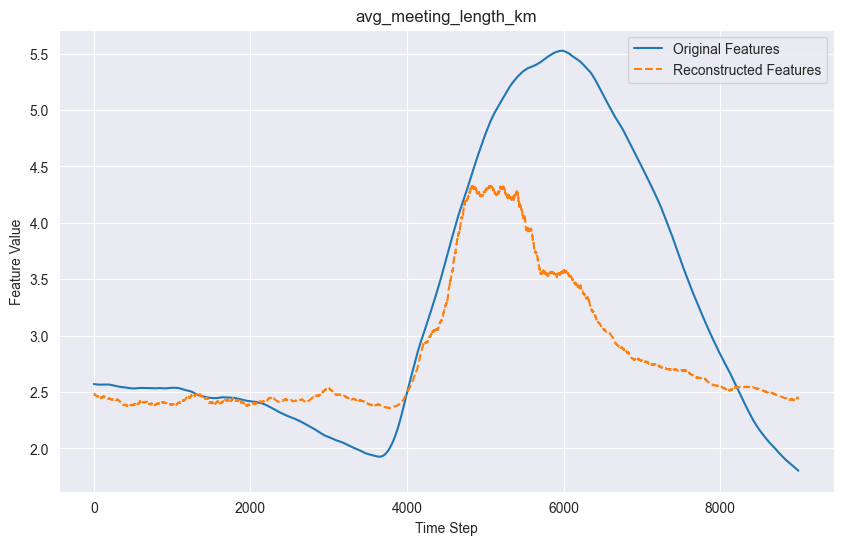

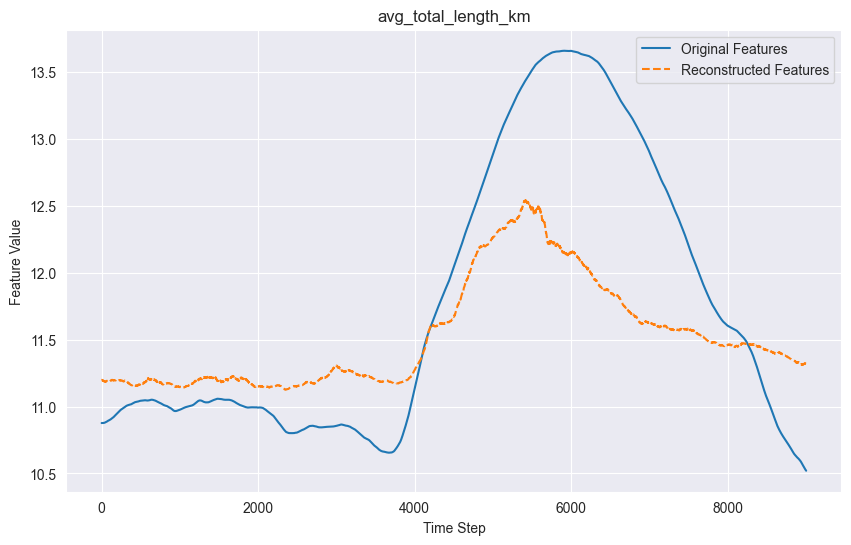

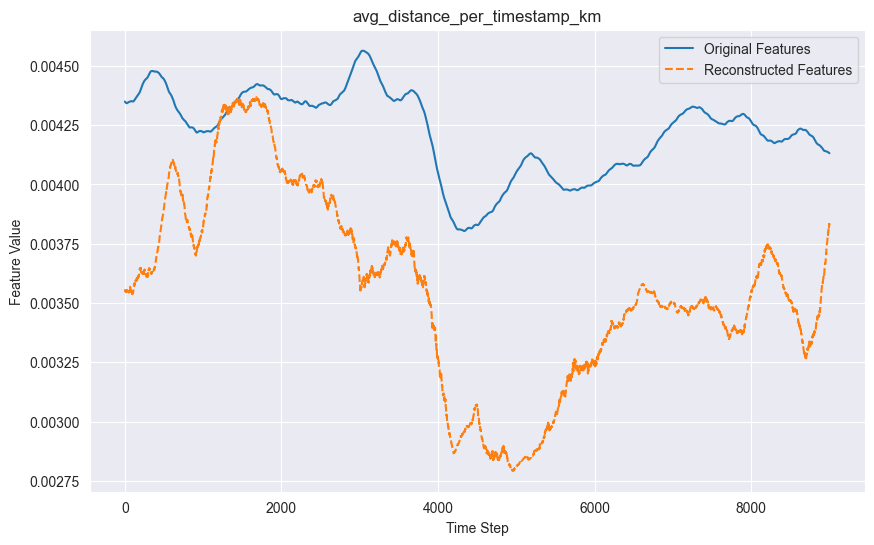

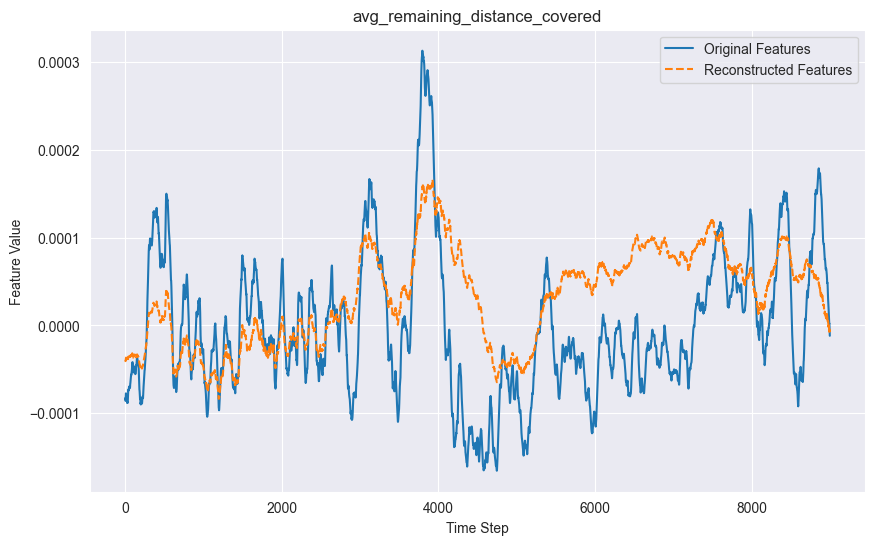

In [21]:
# Predict and assess performance on test set
original, reconstructed = predict(model, test_set_fail, scaler_path, recurrent = False)

# Save metrics plots and dataframes
num_features = min(test_set_fail.shape[1], len(df_proc_fail.columns))
mae, mse, mape = save_predict_plots(original, reconstructed, df_proc_fail.columns, num_features, scaler_path, model_type = 'dense_fail', plot = False, compute_df = True)

# Plot test set reconstruction performance
for column in range(0, len(df_proc.columns)):
    plt.figure(figsize = (10, 6))
    plt.plot(original[1800:, column], label = 'Original Features')
    plt.plot(reconstructed[1800:, column], label = 'Reconstructed Features', linestyle = '--')
    plt.title(df_proc.columns[column])
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

In [22]:
# Loading metrics datasets
mae_fail_df = pd.read_csv("predictions/dense_fail/dense_fail_mae.csv")
mae_fail_df = mae_fail_df.dropna().reset_index(drop = True)
mse_fail_df = pd.read_csv("predictions/dense_fail/dense_fail_mse.csv")
mse_fail_df = mse_fail_df.dropna().reset_index(drop = True)
mape_fail_df = pd.read_csv("predictions/dense_fail/dense_fail_mape.csv")
mape_fail_df = mape_fail_df.dropna().reset_index(drop = True)

# Computing failed_requests index
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)
for column in df_proc_fail.columns:
    df_fail[column] = np.around(df_fail[column].astype(float), 5)
    df_fail[column] = df_fail[column].rolling(window = 300).mean()
df_fail = df_fail[5400:-1800].reset_index(drop = True)
failed_requests_fail = [0] * len(df_fail)
w_failed_requests_fail = [0] * len(df_fail)
factor = df['rides_requested'].mean()
for i in range(0, len(df_fail)):
    if df_fail['rides_requested'][i] == 0:
        failed = 0
        w_failed = 0
    else:
        failed, w_failed = compute_failed_requests(float(df_fail['rides_not_served'][i]), float(df_fail['rides_requested'][i]), factor)
    failed_requests_fail[i] = failed
    w_failed_requests_fail[i] = w_failed
 
'''   
# Setting thresholds
failed_requests_fail = pd.Series(failed_requests_fail)
threshold = 0.5
green_line_timestamp = 0
#exceed_indexes = failed_requests_fail[failed_requests_fail >= threshold]
for i in range(3600, len(failed_requests_fail) - 20 + 1):
    window = failed_requests_fail[i:i+20]
    # Calculate the percentage of observations >= threshold
    percentage = sum(value >= threshold for value in window) / 20
    if percentage >= threshold:
        # Return the index of the first observation in the window meeting the criteria
        green_line_timestamp = window.index[0]
        break
'''

'   \n# Setting thresholds\nfailed_requests_fail = pd.Series(failed_requests_fail)\nthreshold = 0.5\ngreen_line_timestamp = 0\n#exceed_indexes = failed_requests_fail[failed_requests_fail >= threshold]\nfor i in range(3600, len(failed_requests_fail) - 20 + 1):\n    window = failed_requests_fail[i:i+20]\n    # Calculate the percentage of observations >= threshold\n    percentage = sum(value >= threshold for value in window) / 20\n    if percentage >= threshold:\n        # Return the index of the first observation in the window meeting the criteria\n        green_line_timestamp = window.index[0]\n        break\n'

## Overall anomaly

We compute the overall performance across all the indicators, by taking the normalized mean of the reconstruction error across all columns.

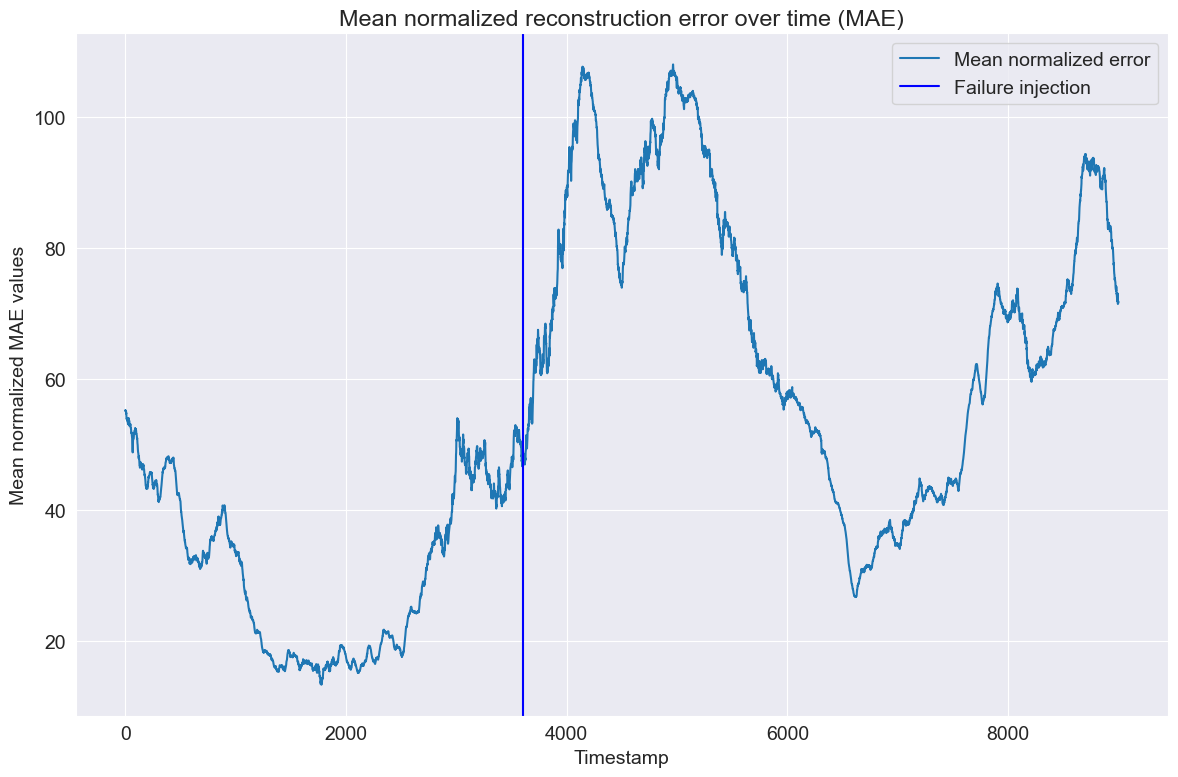

In [23]:
# Plot final results (MAE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []

for indicator in mae_df.columns:
    errors = mae_df[indicator]
    errors_fail = mae_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mae_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MAE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MAE_dense.png', dpi = 300)
plt.show()

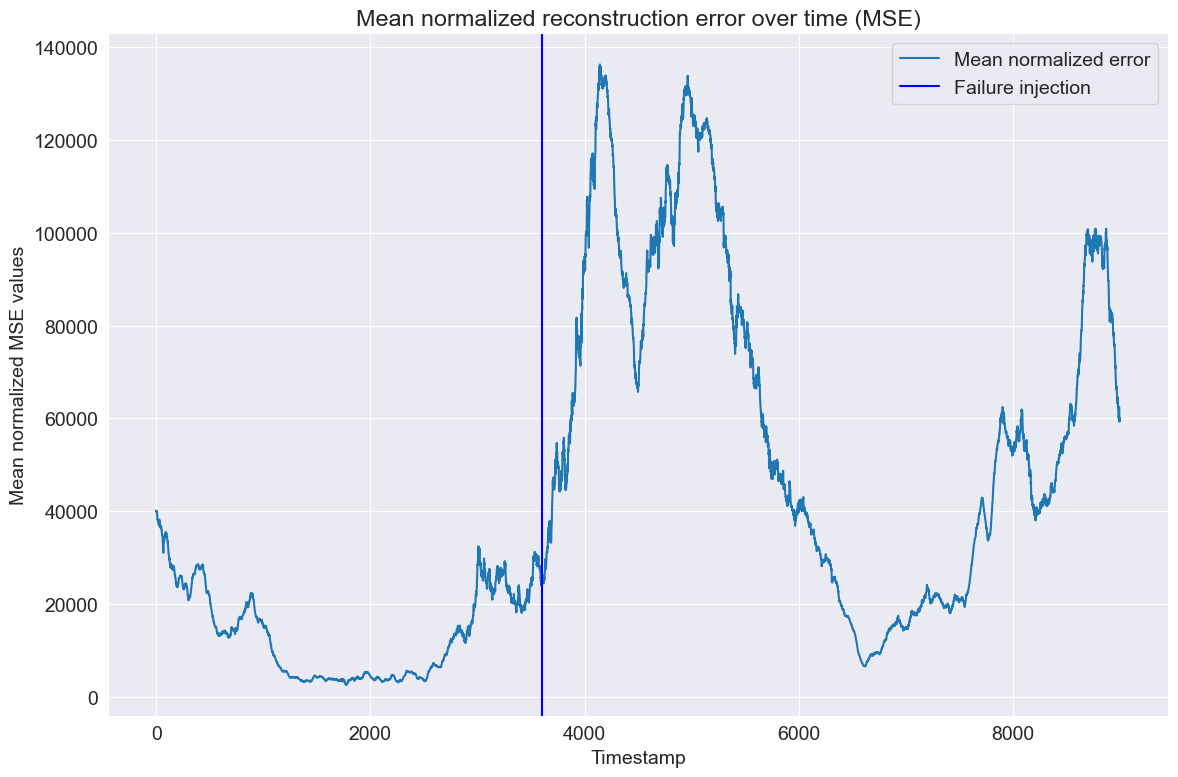

In [24]:
# Plot final results (MSE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mse_fail_df.index)
normalized_thresholds_99 = []

for indicator in mse_df.columns:
    errors = mse_df[indicator]
    errors_fail = mse_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mse_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MSE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MSE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MSE_dense.png', dpi = 300)
plt.show()

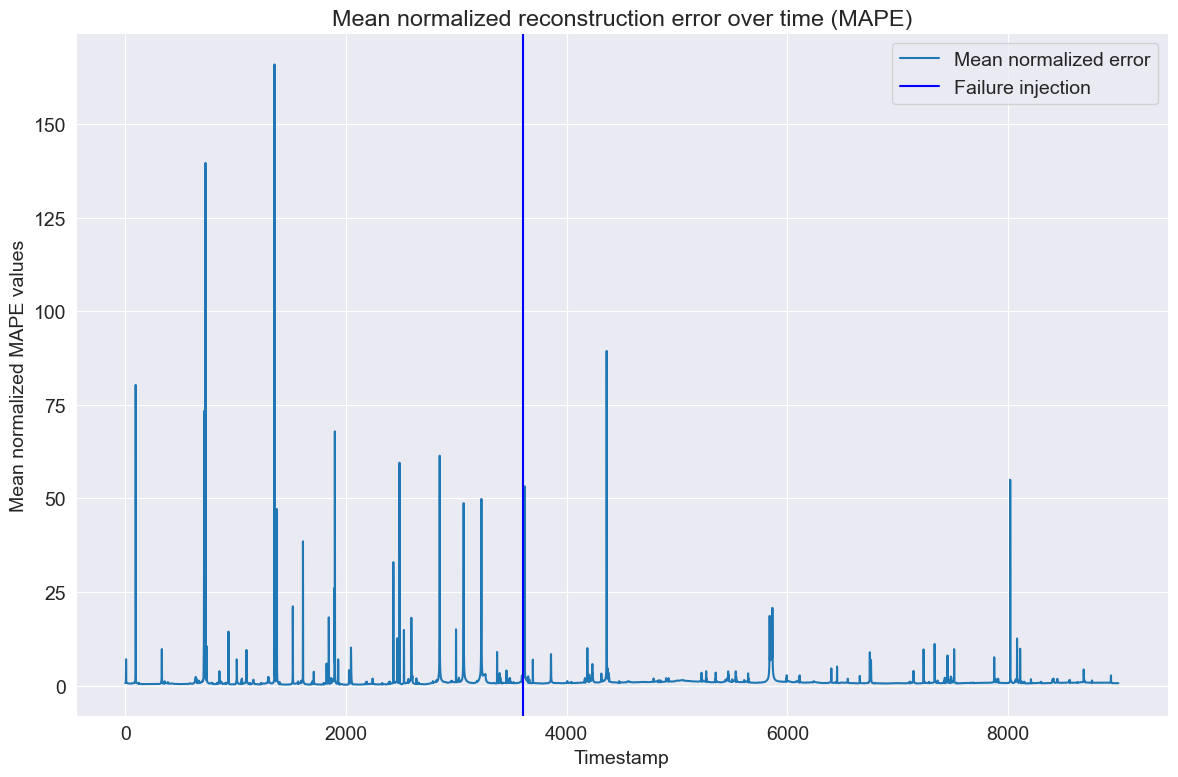

In [25]:
# Plot final results (MAPE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mape_fail_df.index)
normalized_thresholds_99 = []

for indicator in mape_df.columns:
    errors = mape_df[indicator]
    errors_fail = mape_fail_df[indicator]
    
    # Normalize errors  wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors

mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mape_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MAPE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MAPE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MAPE_dense.png', dpi = 300)
plt.show()

## Clustering indicators

Now we apply three different filters, using three disjoint subsets of indicators concerning three different aspects of our Smart EcoSystem: **system**, **environment** and **people**.

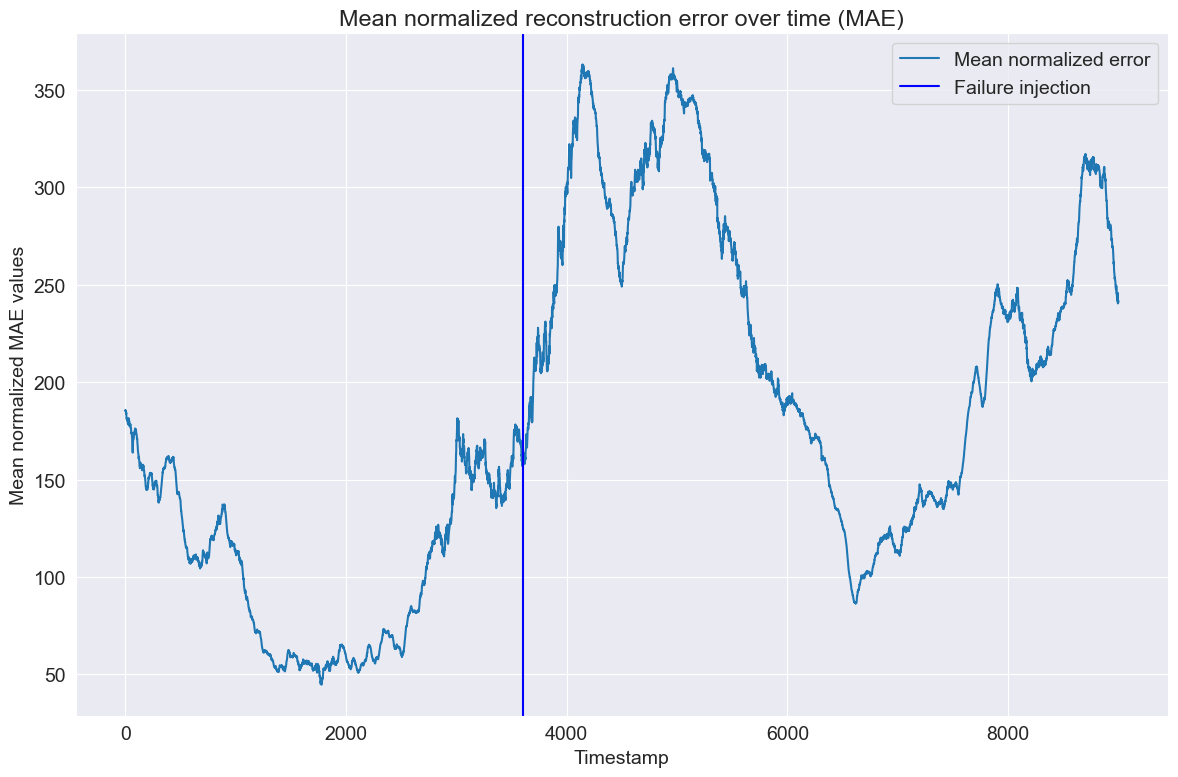

In [26]:
# System filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
system_columns = ['idle_drivers', 'moving_drivers', 'rides_in_progress', 'on_road_drivers', 'pickup_drivers', 'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price', 'avg_diff_price']

mae_df_system = mae_df[system_columns]
mae_fail_df_system = mae_fail_df[system_columns]

for indicator in mae_df_system.columns:
    errors = mae_df_system[indicator]
    errors_fail = mae_fail_df_system[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mae_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MAE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/system_' + fail + '_' + hour + '_MAE_dense.png', dpi = 300)
plt.show()

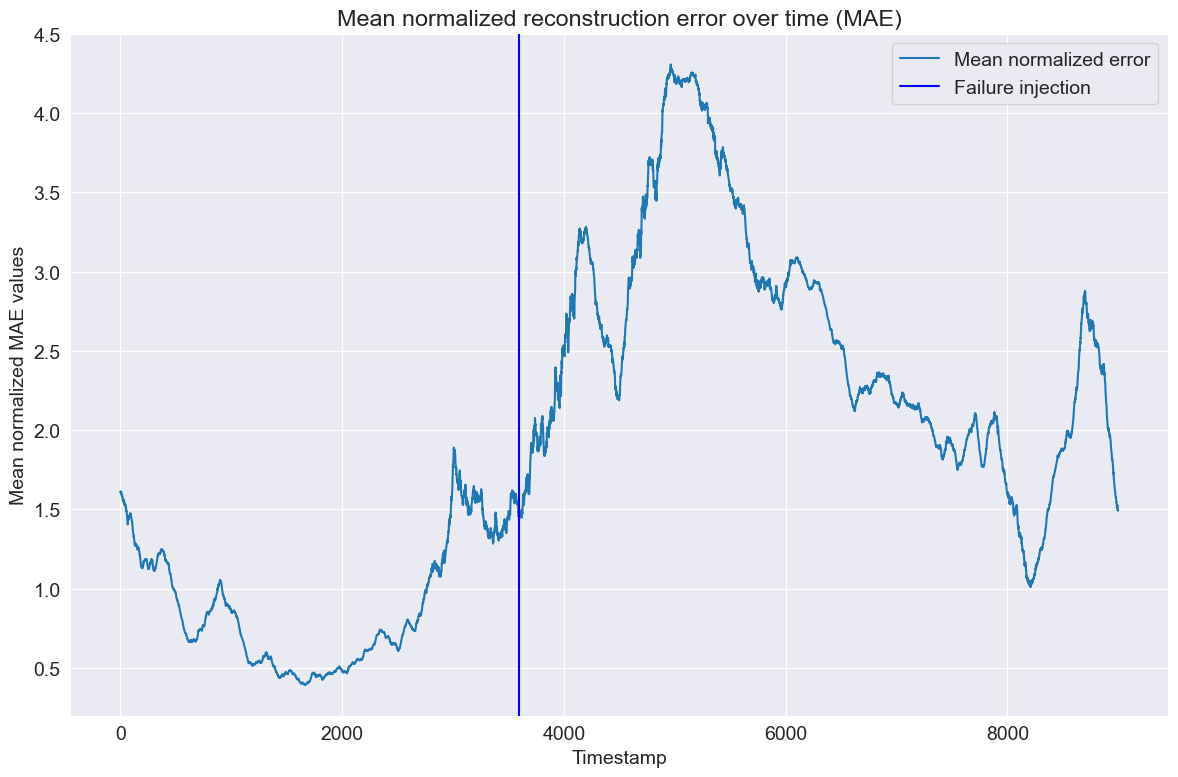

In [27]:
# Environment filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
env_columns = ['avg_current_error_ride_distance', 'avg_speed_max_speed', 'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min', 'avg_expected_meeting_time_min', 'avg_expected_total_time_min', 'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min', 'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km', 'avg_distance_per_timestamp_km', 'avg_remaining_distance_covered']

mae_df_env = mae_df[env_columns]
mae_fail_df_env = mae_fail_df[env_columns]

for indicator in mae_df_env.columns:
    errors = mae_df_env[indicator]
    errors_fail = mae_fail_df_env[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mae_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MAE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/env_' + fail + '_' + hour + '_MAE_dense.png', dpi = 300)
plt.show()

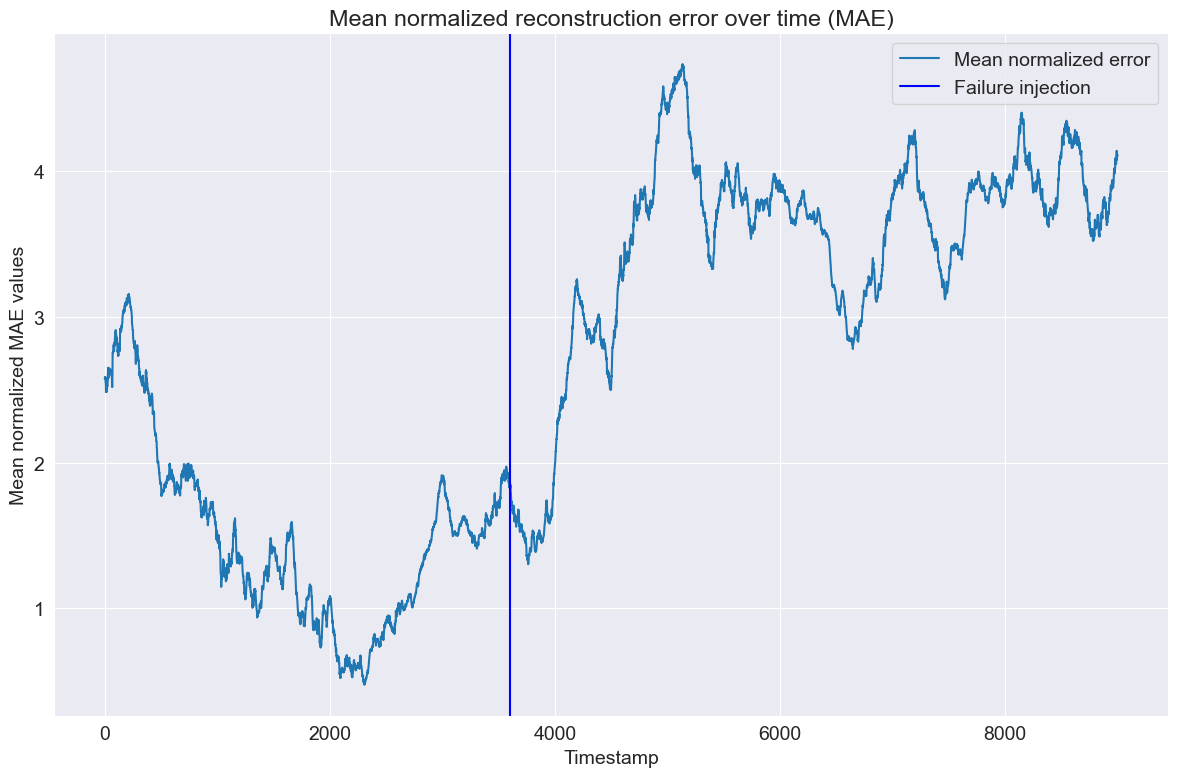

In [28]:
# People filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
people_columns = ['rides_requested', 'rides_canceled', 'rides_accepted', 'rides_rejections', 'responding_drivers', 'pending_customers', 'avg_rejections_before_accepted']

mae_df_people = mae_df[people_columns]
mae_fail_df_people = mae_fail_df[people_columns]

for indicator in mae_df_people.columns:
    errors = mae_df_people[indicator]
    errors_fail = mae_fail_df_people[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)[1800:].reset_index(drop = True)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
#plt.axhline(y = metrics_df['mae_99'][0], color = 'red', linestyle = '--', label = 'Reconstruction error threshold')
plt.axvline(x = 3600, color = 'blue', label = 'Failure injection')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('Mean normalized MAE values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/people_' + fail + '_' + hour + '_MAE_dense.png', dpi = 300)
plt.show()